Setup
===

In [1]:
# import pystan
import stanity
n_jobs = 4
import pandas as pd
import seaborn as sns
sns.set_color_codes()
%pylab inline
from scipy.stats import norm, truncnorm

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_directory = '../data/'

In [6]:
from pystan.misc import _summary, _array_to_table
def _print_stanfit(fit, pars=None, probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=2):
        if fit.mode == 1:
            return "Stan model '{}' is of mode 'test_grad';\n"\
                   "sampling is not conducted.".format(fit.model_name)
        elif fit.mode == 2:
            return "Stan model '{}' does not contain samples.".format(fit.model_name)
        if pars is None:
            pars = fit.sim['pars_oi']
            fnames = fit.sim['fnames_oi']

        n_kept = [s - w for s, w in zip(fit.sim['n_save'], fit.sim['warmup2'])]
        header = ""#Inference for Stan model: {}.\n".format(fit.model_name)
        header += "{} chains, each with iter={}; warmup={}; thin={}; \n"
        header = header.format(fit.sim['chains'], fit.sim['iter'], fit.sim['warmup'],
                               fit.sim['thin'], sum(n_kept))
        header += "post-warmup draws per chain={}, total post-warmup draws={}.\n\n"
        header = header.format(n_kept[0], sum(n_kept))
        footer = "\n\nSamples were drawn using {} at {}.\n"\
#             "For each parameter, n_eff is a crude measure of effective sample size,\n"\
#             "and Rhat is the potential scale reduction factor on split chains (at \n"\
#             "convergence, Rhat=1)."
        sampler = fit.sim['samples'][0]['args']['sampler_t']
        date = fit.date.strftime('%c')  # %c is locale's representation
        footer = footer.format(sampler, date)
        s = _summary(fit, pars, probs)
        body = _array_to_table(s['summary'], s['summary_rownames'],
                               s['summary_colnames'], digits_summary)
        return header + body + footer
    
def plot_time_series_inference(model_fit, var='Y_sim', x=None,
                               ax=None, ind=0, **kwargs):
    from scipy.stats import scoreatpercentile
    ci_thresholds = [2.5, 25, 75, 97.5]
    if len(model_fit[var].shape)<3:
        data = model_fit[var]
    else:
        data = model_fit[var][:,ind,:]
    CIs = scoreatpercentile(data, ci_thresholds, axis=0)
    CIs = pd.DataFrame(data=CIs.T, columns=ci_thresholds)
    if ax is None:
        ax=gca()
    if x is None:
        x = arange(data.shape[1])
    ax.fill_between(x, CIs[2.5], CIs[97.5],alpha=.5, **kwargs)
    ax.fill_between(x, CIs[25], CIs[75], **kwargs)
    
    

Define Single-Time-Series Models and Ensure They Correctly Fit to Simulated Data
===

In [4]:
model_code = {}

model_code['improvement~N(mu,sigma)'] = """
functions{
    int first_observation_ind(vector my_array){
        int t;
        t = 1;
        while(my_array[t] < -900){
          t = t+1;
        }
        return t;
    }
    
    int last_observation_ind(vector my_array, int length){
        int last_observation;
        last_observation = 0; 
        for(t in 1:length){
          if(my_array[t] > -900){
              last_observation = t;
          }
        }
        return last_observation;
    }
    
    
    int count_n_observations(vector my_array) {
        int count;
        count = 0;
        for (t in 1:num_elements(my_array)) {
            if(my_array[t] > -900){
                count = count + 1;
            }
        }
        return count;
    }
    
    real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
        return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
    }
}

data {
    int N_time_periods; // number of time periods
    vector[N_time_periods] Y; // value each time period
    
    int N_time_periods_for_inference;
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
 
}

transformed data {
  int first_observation;
  int last_observation;
  int N_observed_time_periods_for_inference;
  int r_offset;
  int n_observations;

  first_observation = first_observation_ind(Y[1:N_time_periods_for_inference]);
  last_observation = last_observation_ind(Y[1:N_time_periods_for_inference], 
                      N_time_periods_for_inference);
                      
  N_observed_time_periods_for_inference = last_observation-first_observation + 1;
  r_offset = first_observation-1;
  
  n_observations = count_n_observations(Y);

}
  
parameters {
    real<lower = 0> mu;
    real<lower = 0> sigma;

    vector<lower = 0,upper = 1>[N_observed_time_periods_for_inference-1] r_raw; // updates
}

transformed parameters {
  // Identify where the first and last non-missing data points are in Y
  vector<lower = 0>[N_observed_time_periods_for_inference-1] r; // updates
  
  {
  // Dictate that the total change between each pair of observations is equal to the observed change between them
  // This is relevant for time periods with missing data
  int most_recent_observation;
  most_recent_observation = first_observation;
  for(t in first_observation+1:last_observation) {
      if(Y[t] > -900) {
        r[(most_recent_observation-r_offset):((t-1)-r_offset)] = 
        r_raw[(most_recent_observation-r_offset):((t-1)-r_offset)] /
        sum(r_raw[(most_recent_observation-r_offset):((t-1)-r_offset)]) * 
        (Y[t]-Y[most_recent_observation]);
        most_recent_observation = t;
        }
    }
    }
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

    for(t in 1:N_observed_time_periods_for_inference-1){
        target += lower_truncated_normal_lpdf(r[t] | mu, sigma, 0);
    }
}

generated quantities {
    vector[N_time_periods] Y_sim;
    vector[N_time_periods] log_likelihood;
    real mean_change;
    real variance_change;
    
    mean_change = mean(r);
    variance_change = variance(r);
    
    //Fill out data in the missing periods
    for(t in first_observation:last_observation) {
      if(Y[t] > -900){
          Y_sim[t] = Y[t];
      } else{
          Y_sim[t] = Y_sim[t-1] + r[(t-1)-r_offset];
      } 
    }
    {
    real increase_size;
    //Fill out future data points
    for(t in last_observation+1:N_time_periods){
        // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
        // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
        increase_size = -1.0;  
        while (increase_size<0){
            increase_size = normal_rng(mu,sigma);
        }
        Y_sim[t] = increase_size + Y_sim[t-1];
    }
    }
    
    //Fill out past data points
    {
    int t;
    real increase_size;
    t = first_observation;
    while(t>1){
        increase_size = -1.0;  
        while (increase_size<0){
            increase_size = normal_rng(mu,sigma);
        }
        Y_sim[t-1] = Y_sim[t] - increase_size;
        t = t-1;
    }
    }
    
    for(t in 2:N_time_periods){
        if(Y[t] > -900){
                log_likelihood[t] = lower_truncated_normal_lpdf(Y[t]-Y_sim[t-1]| mu, sigma, 0);
        }
    }
}
"""


model_code['improvement~p(theta)N(mu,sigma)'] = """
functions{
    int first_observation_ind(vector my_array){
        int t;
        t = 1;
        while(my_array[t] < -900){
          t = t+1;
        }
        return t;
    }
    
    int last_observation_ind(vector my_array, int length){
        int last_observation;
        last_observation = 0; 
        for(t in 1:length){
          if(my_array[t] > -900){
              last_observation = t;
          }
        }
        return last_observation;
    }
    
    
    int count_n_observations(vector my_array) {
        int count;
        count = 0;
        for (t in 1:num_elements(my_array)) {
            if(my_array[t] > -900){
                count = count + 1;
            }
        }
        return count;
    }
    
    real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
        return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
    }
}

data {
    int N_time_periods; // number of time periods
    vector[N_time_periods] Y; // value each time period
    
    int N_time_periods_for_inference;
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
    
    real theta_prior_location;
    real theta_prior_scale;
}

transformed data {
  int first_observation;
  int last_observation;
  int N_observed_time_periods_for_inference;
  int r_offset;
  int n_observations;

  first_observation = first_observation_ind(Y[1:N_time_periods_for_inference]);
  last_observation = last_observation_ind(Y[1:N_time_periods_for_inference], 
                      N_time_periods_for_inference);
                      
  N_observed_time_periods_for_inference = last_observation-first_observation + 1;
  r_offset = first_observation-1;
  
  n_observations = count_n_observations(Y);

}
  
parameters {
    real<lower = 0> mu;
    real<lower = 0> sigma;
    real<lower = 0, upper = 1> theta;

    vector<lower = 0,upper = 1>[N_observed_time_periods_for_inference-1] r_raw; // updates
}

transformed parameters {
  // Identify where the first and last non-missing data points are in Y
  vector<lower = 0>[N_observed_time_periods_for_inference-1] r; // updates
  
  {
  // Dictate that the total change between each pair of observations is equal to the observed change between them
  // This is relevant for time periods with missing data
  int most_recent_observation;
  most_recent_observation = first_observation;
  for(t in first_observation+1:last_observation) {
      if(Y[t] > -900) {
        r[(most_recent_observation-r_offset):((t-1)-r_offset)] = 
        r_raw[(most_recent_observation-r_offset):((t-1)-r_offset)] /
        sum(r_raw[(most_recent_observation-r_offset):((t-1)-r_offset)]) * 
        (Y[t]-Y[most_recent_observation]);
        most_recent_observation = t;
        }
    }
    }
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    theta ~ normal(theta_prior_location, theta_prior_scale);

    for(t in 1:N_observed_time_periods_for_inference-1){
        target += log_mix(theta, lower_truncated_normal_lpdf(r[t] | mu, sigma, 0), 
                      lower_truncated_normal_lpdf(r[t] | 0, 0.01, 0));
    }
}

generated quantities {
    vector[N_time_periods] Y_sim;
    vector[N_time_periods] log_likelihood;
    real mean_change;
    real variance_change;
    
    mean_change = mean(r);
    variance_change = variance(r);
    //Fill out data in the missing periods
    for(t in first_observation:last_observation) {
      if(Y[t] > -900){
          Y_sim[t] = Y[t];
      } else{
          Y_sim[t] = Y_sim[t-1] + r[(t-1)-r_offset];
      } 
    }
    {
    real increase_size;
    //Fill out future data points
    for(t in last_observation+1:N_time_periods){
        // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
        // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
        increase_size = -1.0;  
        while (increase_size<0){
            increase_size = normal_rng(mu,sigma);
        }
        Y_sim[t] = bernoulli_rng(theta) * increase_size + Y_sim[t-1];
    }
    }
    
    //Fill out past data points
    {
    int t;
    real increase_size;
    t = first_observation;
    while(t>1){
        increase_size = -1.0;  
        while (increase_size<0){
            increase_size = normal_rng(mu,sigma);
        }
        Y_sim[t-1] = Y_sim[t] - bernoulli_rng(theta) * increase_size;
        t = t-1;
    }
    }
    
    for(t in 2:N_time_periods){
        if(Y[t] > -900){
            if((Y[t]-Y_sim[t-1])==0) {
                log_likelihood[t] = log(1-theta);
            } else {
                log_likelihood[t] = log(theta) + lower_truncated_normal_lpdf(Y[t]-Y_sim[t-1]| mu, sigma, 0);
            }
        }
    }
}
"""

Reusing model.
Ran in 12.673 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.92  1.3e-3   0.08   4.76   4.87   4.92   4.97   5.08   4000    1.0
sigma   0.81  1.1e-3   0.07   0.69   0.76    0.8   0.85   0.95   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:22:08 2016.

mu: 5.00, inferred mu: 4.92
sigma: 1.00, inferred sigma: 0.81


(0, 160.0)

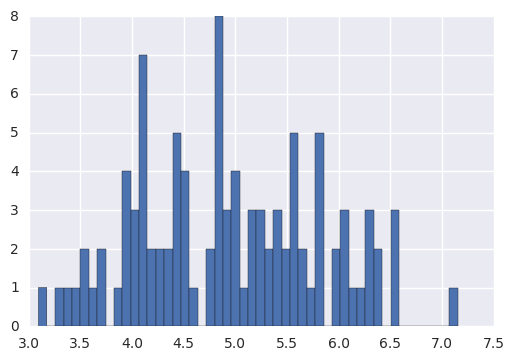

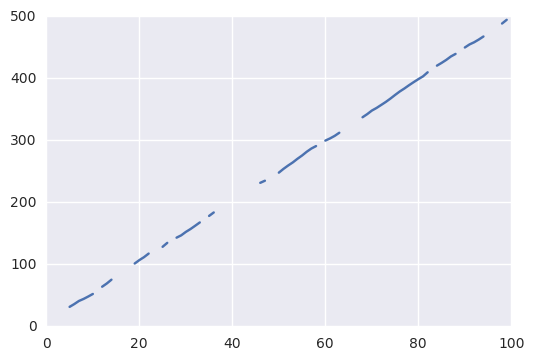

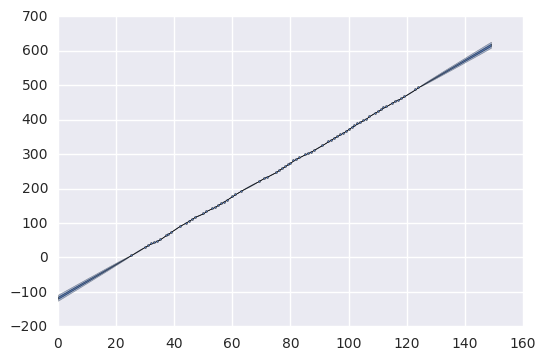

In [7]:
### Random walk, missing data, positive steps
p_missing = 0.3
mu = 5
sigma = 1
n = 100


a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
missing[-1] = False
time_series[missing]=nan


hist(data, bins=50)
figure()
plot(time_series)

n_past_steps = 25
n_future_steps = 25
stan_data = {'N_time_periods': len(time_series)+n_future_steps+n_past_steps,
            'N_time_periods_for_inference': len(time_series)+n_past_steps,
             'Y': pd.Series(concatenate((empty(n_past_steps)*nan,
                                         time_series,
                                         empty(n_future_steps)*nan),0)).fillna(-999),
            'mu_prior_location': 3,
            'mu_prior_scale': 1,
            'sigma_prior_location': 1,
            'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code['improvement~N(mu,sigma)'], data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma']))
print("mu: %.2f, inferred mu: %.2f"%(mu, model_fit['mu'].mean()))
print("sigma: %.2f, inferred sigma: %.2f"%(sigma, model_fit['sigma'].mean()))

figure()
plot_time_series_inference(model_fit)
scatter(arange(len(time_series))+n_past_steps, time_series,s=2)
xlim(xmin=0)
# ylim(ymin=0)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ee6a3b3f6de2e2d0b5ddcab6f7abfdb NOW.


NOT reusing model.
Ran in 70.316 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.54    0.02   0.12    4.3   4.46   4.54   4.62   4.78     26   1.06
sigma   1.11    0.02   0.11   0.93   1.03    1.1   1.18   1.35     24   1.07
theta    0.9  4.9e-4   0.03   0.83   0.88    0.9   0.92   0.95   4000   1.03

Samples were drawn using NUTS at Sat Nov 12 06:23:19 2016.

mu: 5.00, inferred mu: 4.54
sigma: 1.00, inferred sigma: 1.11
theta: 0.80, inferred theta: 0.90


(0, 160.0)

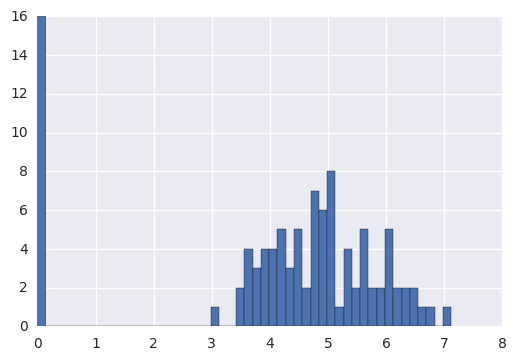

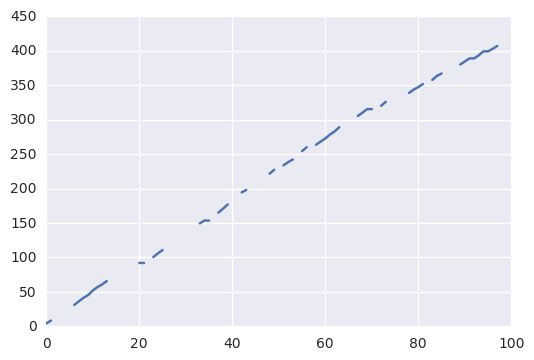

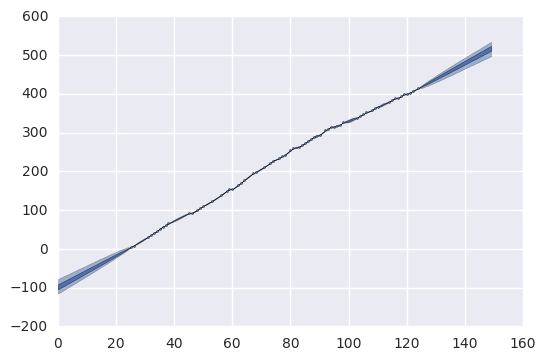

In [8]:
### Random walk, missing data, positive steps, possibility of no step, noise on no step
p_missing = 0.3
theta = .8
mu = 5
sigma = 1
n = 100

improvement = rand(n)<theta
improvement[0] = True

a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)
data[~improvement]=0

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
missing[-1] = False
time_series[missing]=nan


hist(data, bins=50)
figure()
plot(time_series)



n_past_steps = 25
n_future_steps = 25
stan_data = {'N_time_periods': len(time_series)+n_future_steps+n_past_steps,
            'N_time_periods_for_inference': len(time_series)+n_past_steps,
             'Y': pd.Series(concatenate((empty(n_past_steps)*nan,
                                         time_series,
                                         empty(n_future_steps)*nan),0)).fillna(-999),
           'theta_prior_location': .8,
           'theta_prior_scale': 2,
            'mu_prior_location': 3,
            'mu_prior_scale': 1,
            'sigma_prior_location': 1,
            'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code['improvement~p(theta)N(mu,sigma)'], data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma','theta']))

print("mu: %.2f, inferred mu: %.2f"%(mu, model_fit['mu'].mean()))
print("sigma: %.2f, inferred sigma: %.2f"%(sigma, model_fit['sigma'].mean()))
print("theta: %.2f, inferred theta: %.2f"%(theta, model_fit['theta'].mean()))

figure()
plot_time_series_inference(model_fit)
scatter(arange(len(time_series))+n_past_steps, time_series,s=2)
xlim(xmin=0)
# ylim(ymin=0)

Run Single-Time-Series Models on Empirical Performance Data
====

In [9]:
data = pd.read_csv(data_directory+'time_series.csv',index_col=0)
data = data.reindex(arange(data.index[0],data.index[-1]+1))
metadata = pd.read_csv(data_directory+'time_series_metadata.csv')
technology_models = {}
technology_models_prediction = {}

38 technologies
------------------------------------
integrated_circuit_memory_transistors_per_die
------------------------------------
Reusing model.
Ran in 3.146 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.13  1.3e-3   0.05   0.02    0.1   0.14   0.17   0.21   1441    1.0
sigma   0.17  1.0e-3   0.04   0.11   0.14   0.16   0.19   0.25   1389    1.0

Samples were drawn using NUTS at Sat Nov 12 06:23:24 2016.

Reusing model.
Ran in 4.348 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.16  1.6e-3   0.05   0.03   0.13   0.17   0.19   0.24   1074    1.0
sigma   0.16  1.2e-3   0.04    0.1   0.13   0.15   0.18   0.25   1065    1.0
theta   0.94  1.6e-3   0.05   0.81   0.

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 2.351 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.01  1.6e-4   0.01 1.9e-4 2.9e-3 7.3e-3   0.01   0.04   4000    1.0
sigma   0.27  4.5e-4   0.03   0.23   0.26   0.27   0.29   0.33   3665    1.0

Samples were drawn using NUTS at Sat Nov 12 06:26:19 2016.

Reusing model.
Ran in 5.763 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.09  1.3e-3   0.08 2.6e-3   0.03   0.07   0.13   0.31   4000    1.0
sigma   0.57  9.8e-3   0.14   0.37   0.47   0.54   0.64    0.9    203   1.04
theta   0.31  2.3e-3   0.07   0.18   0.26   0.31   0.36   0.46    985   1.01

Samples were drawn using NUTS at Sat Nov 12 06:26:25 2016.

------------------------------------
Flywheel_kwh_kg

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 1.036 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu   10.0e-3  1.4e-4 9.2e-3 2.8e-4 3.1e-3 7.5e-3   0.01   0.03   4000    1.0
sigma   0.08  2.3e-4   0.01   0.06   0.07   0.08   0.09   0.11   3101    1.0

Samples were drawn using NUTS at Sat Nov 12 06:26:26 2016.

Reusing model.
Ran in 2.252 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.03  3.6e-4   0.02 8.8e-4 9.6e-3   0.02   0.04   0.09   3960    1.0
sigma   0.11  5.3e-4   0.03   0.07   0.09    0.1   0.12   0.17   2563    1.0
theta    0.6  2.5e-3   0.13   0.34    0.5   0.59   0.68   0.86   2797    1.0

Samples were drawn using NUTS at Sat Nov 12 06:26:28 2016.

------------------------------------
AC_electricity_

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 2.844 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    7.7e-3  1.1e-4 6.9e-3 2.0e-4 2.5e-3 5.7e-3   0.01   0.03   4000    1.0
sigma    0.1  1.6e-4 8.4e-3   0.08   0.09    0.1   0.11   0.12   2794    1.0

Samples were drawn using NUTS at Sat Nov 12 06:26:31 2016.

Reusing model.
Ran in 4.960 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.01  1.7e-4   0.01 4.6e-4 4.2e-3 9.0e-3   0.02   0.04   4000    1.0
sigma   0.11  2.3e-4   0.01   0.09    0.1   0.11   0.12   0.13   2570    1.0
theta   0.85  2.2e-3   0.09   0.66   0.79   0.86   0.91   0.99   1461    1.0

Samples were drawn using NUTS at Sat Nov 12 06:26:37 2016.

------------------------------------
DC_electricity_

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 1.151 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    8.8e-3  1.1e-4 7.2e-3 3.1e-4 3.2e-3 7.0e-3   0.01   0.03   4000    1.0
sigma   0.05  1.4e-4 7.6e-3   0.04   0.04   0.05   0.05   0.06   2880    1.0

Samples were drawn using NUTS at Sat Nov 12 06:26:38 2016.

Reusing model.
Ran in 7.558 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.09  5.8e-3   0.02   0.07   0.07   0.09   0.09   0.14     10   1.19
sigma   0.01  1.5e-3   0.02 1.4e-3 3.7e-3 6.6e-3   0.01   0.05    149   1.02
theta   0.38    0.03    0.1   0.18    0.3   0.37   0.45   0.59     17   1.09

Samples were drawn using NUTS at Sat Nov 12 06:26:46 2016.

------------------------------------
combustion_air_

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 0.945 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    7.2e-3  1.0e-4 6.4e-3 1.9e-4 2.3e-3 5.4e-3   0.01   0.02   4000    1.0
sigma   0.06  1.5e-4 8.7e-3   0.04   0.05   0.06   0.06   0.08   3515    1.0

Samples were drawn using NUTS at Sat Nov 12 06:26:47 2016.

Reusing model.
Ran in 2.553 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.11  5.5e-3   0.13 3.1e-3   0.04   0.08   0.13   0.43    563   1.01
sigma   0.23    0.02   0.31   0.04   0.09   0.14   0.24   0.99    366   1.01
theta   0.24  5.3e-3    0.1   0.07   0.17   0.23   0.31   0.47    384   1.01

Samples were drawn using NUTS at Sat Nov 12 06:26:50 2016.

------------------------------------
combustion_air_

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 2.257 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    3.8e-3  5.8e-5 3.6e-3 1.1e-4 1.1e-3 2.7e-3 5.4e-3   0.01   4000    1.0
sigma   0.08  1.3e-4 7.5e-3   0.06   0.07   0.07   0.08   0.09   3166    1.0

Samples were drawn using NUTS at Sat Nov 12 06:26:52 2016.

Reusing model.
Ran in 4.951 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  7.7e-4   0.04 2.2e-3   0.02   0.05   0.09   0.15   2926    1.0
sigma   0.14  1.5e-3   0.04   0.08   0.12   0.14   0.17   0.25    885    1.0
theta   0.29  1.6e-3   0.07   0.16   0.24   0.29   0.34   0.44   1905    1.0

Samples were drawn using NUTS at Sat Nov 12 06:26:57 2016.

------------------------------------
combustion_air_

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 1.650 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    2.6e-3  4.1e-5 1.9e-3 9.4e-5 9.8e-4 2.2e-3 3.8e-3 6.8e-3   2150    1.0
sigma   0.01  3.1e-5 1.5e-3 7.4e-3 9.1e-3   0.01   0.01   0.01   2128    1.0

Samples were drawn using NUTS at Sat Nov 12 06:26:59 2016.

Reusing model.
Ran in 2.162 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      1.52    0.02   1.26   0.04   0.53   1.24   2.21    4.5   4000    1.0
sigma   9.64     2.8 140.86    0.1   1.03   2.13   4.42  31.08   2522    1.0
theta   0.03  4.0e-4   0.03 7.1e-4 8.2e-3   0.02   0.04    0.1   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:27:02 2016.

------------------------------------
combustion_air_

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 1.954 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    3.2e-3  4.6e-5 2.9e-3 8.4e-5 1.0e-3 2.4e-3 4.7e-3   0.01   4000    1.0
sigma   0.05  8.7e-5 5.5e-3   0.04   0.05   0.05   0.05   0.06   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:27:04 2016.

Reusing model.
Ran in 5.055 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.08  1.6e-3   0.06 3.2e-3   0.04   0.08   0.11   0.21   1466    1.0
sigma   0.15  6.4e-3   0.11   0.05   0.09   0.13   0.18    0.4    290   1.01
theta   0.19  1.8e-3   0.06   0.08   0.14   0.18   0.23   0.32   1242    1.0

Samples were drawn using NUTS at Sat Nov 12 06:27:09 2016.

------------------------------------
combustion_pass

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 3.257 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    2.6e-3  3.9e-5 2.4e-3 7.4e-5 7.4e-4 1.9e-3 3.7e-3 9.1e-3   4000    1.0
sigma   0.06  8.3e-5 4.7e-3   0.05   0.05   0.06   0.06   0.07   3197    1.0

Samples were drawn using NUTS at Sat Nov 12 06:27:13 2016.

Reusing model.
Ran in 6.068 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  7.3e-4   0.04 2.7e-3   0.02   0.05   0.08   0.14   2914    1.0
sigma   0.13  1.3e-3   0.04   0.07    0.1   0.12   0.15   0.22    897    1.0
theta   0.23  9.4e-4   0.06   0.12   0.19   0.23   0.27   0.35   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:27:19 2016.

------------------------------------
combustion_pass

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 2.350 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    6.2e-4  9.6e-6 6.1e-4 1.2e-5 1.8e-4 4.3e-4 8.8e-4 2.3e-3   4000    nan
sigma   0.01  1.8e-5 1.1e-3   0.01   0.01   0.01   0.01   0.02   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:27:21 2016.

Reusing model.
Ran in 5.866 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.03  1.8e-3   0.05 1.2e-3   0.01   0.03   0.04   0.07    888    1.0
sigma   0.04  4.8e-3   0.13 8.3e-3   0.02   0.03   0.04   0.12    723    1.0
theta    0.1  7.8e-4   0.05   0.03   0.07   0.09   0.13   0.22   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:27:27 2016.

------------------------------------
electricmotor_w

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 4.268 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    9.5e-4  1.4e-5 9.0e-4 2.9e-5 3.0e-4 6.8e-4 1.3e-3 3.4e-3   4000    nan
sigma   0.03  3.7e-5 2.4e-3   0.03   0.03   0.03   0.04   0.04   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:27:32 2016.

Reusing model.
Ran in 9.368 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.11  2.0e-3   0.07 5.2e-3   0.06   0.12   0.16   0.25   1167    1.0
sigma   0.15  6.4e-3   0.11   0.02   0.08   0.13   0.18   0.38    285   1.01
theta   0.08  2.3e-3   0.03   0.03   0.06   0.08    0.1   0.16    209   1.02

Samples were drawn using NUTS at Sat Nov 12 06:27:42 2016.

------------------------------------
electricmotor_w

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 2.865 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    1.7e-3  2.5e-5 1.6e-3 6.2e-5 5.7e-4 1.3e-3 2.5e-3 6.1e-3   4000    1.0
sigma   0.02  3.0e-5 1.9e-3   0.02   0.02   0.02   0.02   0.03   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:27:45 2016.

Reusing model.
Ran in 7.253 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.26  7.5e-3   0.35 8.5e-3   0.08   0.17   0.27   1.29   2202    1.0
sigma   0.54    0.02   0.95 9.6e-3   0.08    0.2   0.59   3.04   1797    1.0
theta   0.05  7.8e-4   0.03 9.1e-3   0.03   0.04   0.06   0.12   1343    1.0

Samples were drawn using NUTS at Sat Nov 12 06:27:52 2016.

------------------------------------
Artificial_Illu

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 2.254 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  8.3e-4   0.04 2.7e-3   0.03   0.06   0.09   0.14   2337    1.0
sigma   0.19  6.2e-4   0.03   0.13   0.17   0.19   0.21   0.25   2302    1.0

Samples were drawn using NUTS at Sat Nov 12 06:27:55 2016.

Reusing model.
Ran in 4.157 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.09  1.7e-3   0.06 3.7e-3   0.04   0.09   0.13    0.2   1016    1.0
sigma   0.19  1.1e-3   0.04   0.12   0.16   0.18   0.21   0.26   1106    1.0
theta   0.88  2.2e-3   0.08   0.71   0.84    0.9   0.94   0.99   1236    1.0

Samples were drawn using NUTS at Sat Nov 12 06:27:59 2016.

------------------------------------
aeroplane_trans

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 2.043 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.01  1.6e-4 8.8e-3 3.3e-4 4.0e-3 9.0e-3   0.02   0.03   3034    1.0
sigma   0.07  1.5e-4 8.3e-3   0.05   0.06   0.07   0.07   0.09   3213    1.0

Samples were drawn using NUTS at Sat Nov 12 06:28:01 2016.

Reusing model.
Ran in 3.152 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.02  2.7e-4   0.01 6.1e-4 6.7e-3   0.01   0.03   0.05   2805    1.0
sigma   0.07  1.8e-4   0.01   0.06   0.07   0.07   0.08    0.1   4000    1.0
theta   0.83  2.5e-3   0.11    0.6   0.76   0.85   0.92   0.99   1801    1.0

Samples were drawn using NUTS at Sat Nov 12 06:28:05 2016.

------------------------------------
Milling_yearlya

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 3.449 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    6.2e-3  9.9e-5 3.8e-3 2.7e-4 3.0e-3 5.9e-3 9.1e-3   0.01   1473   1.01
sigma   0.02  6.4e-5 2.5e-3   0.01   0.02   0.02   0.02   0.02   1518   1.01

Samples were drawn using NUTS at Sat Nov 12 06:28:08 2016.

Reusing model.
Ran in 5.462 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.01  2.0e-4 6.7e-3 5.9e-4 5.7e-3   0.01   0.02   0.03   1157    1.0
sigma   0.02  1.3e-4 4.1e-3   0.01   0.01   0.02   0.02   0.03   1072   1.01
theta   0.71  3.9e-3   0.17   0.35   0.59   0.72   0.85   0.98   1877    1.0

Samples were drawn using NUTS at Sat Nov 12 06:28:14 2016.

------------------------------------
3dprintingSLA_s

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Reusing model.
Ran in 1.043 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.13  1.2e-3   0.02    0.1   0.13   0.13   0.14   0.15    173   1.02
sigma   0.04  1.6e-3   0.02   0.02   0.02   0.03   0.04    0.1    221   1.02

Samples were drawn using NUTS at Sat Nov 12 06:28:15 2016.

Reusing model.
Ran in 1.752 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.15  6.5e-3   0.02   0.12   0.14   0.15   0.16   0.18      8   1.21
sigma   0.02  1.4e-3   0.02 5.7e-3   0.01   0.02   0.03   0.07    177   1.01
theta   0.83    0.03   0.11   0.57   0.75   0.85   0.92   0.99     13   1.13

Samples were drawn using NUTS at Sat Nov 12 06:28:17 2016.

------------------------------------


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 1.253 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.04  6.4e-4   0.03 1.4e-3   0.02   0.04   0.06   0.11   2092    1.0
sigma   0.12  5.4e-4   0.02   0.08   0.11   0.12   0.14   0.18   1996    1.0

Samples were drawn using NUTS at Sat Nov 12 06:28:19 2016.

Reusing model.
Ran in 3.055 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.14  1.8e-3   0.04   0.02   0.13   0.15   0.16   0.19    471   1.01
sigma   0.07  6.0e-3   0.05   0.02   0.03   0.05   0.09   0.19     59   1.05
theta   0.67  5.5e-3   0.11   0.44    0.6   0.68   0.75   0.87    382   1.01

Samples were drawn using NUTS at Sat Nov 12 06:28:22 2016.

------------------------------------
superconductivi

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ran in 2.946 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    1.4e-3  2.3e-5 1.5e-3 3.6e-5 4.1e-410.0e-4 2.0e-3 5.3e-3   4000    1.0
sigma   0.06  7.6e-5 4.8e-3   0.05   0.06   0.06   0.06   0.07   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:28:25 2016.

Reusing model.
Ran in 5.153 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.18  3.0e-3   0.16 7.6e-3   0.07   0.15   0.24   0.55   2786    1.0
sigma   0.42  7.4e-3   0.31   0.14   0.23   0.33   0.49   1.31   1763    1.0
theta   0.06  4.4e-4   0.03   0.02   0.04   0.06   0.08   0.13   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:28:30 2016.



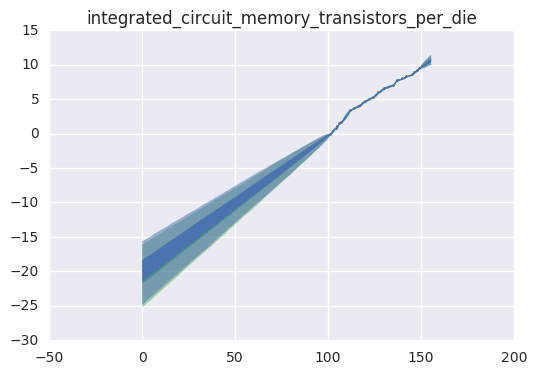

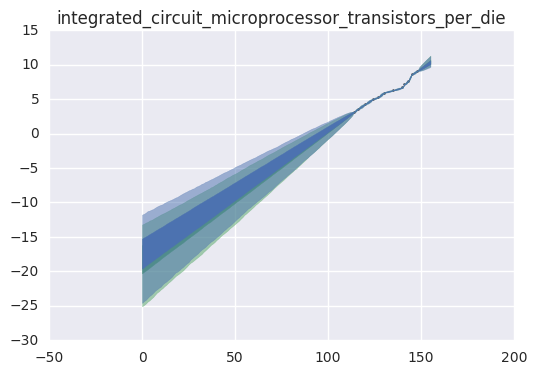

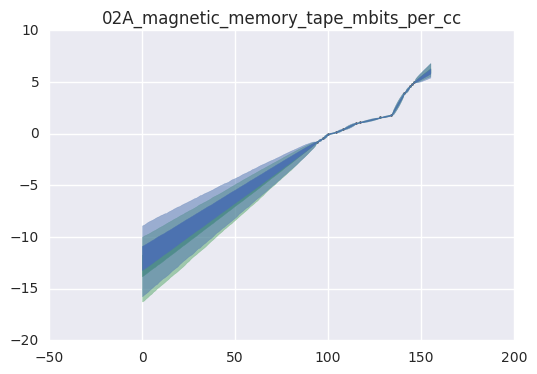

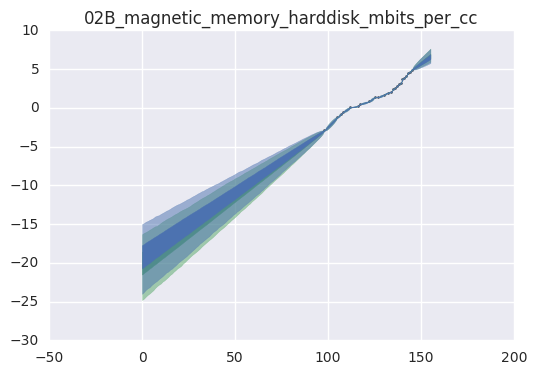

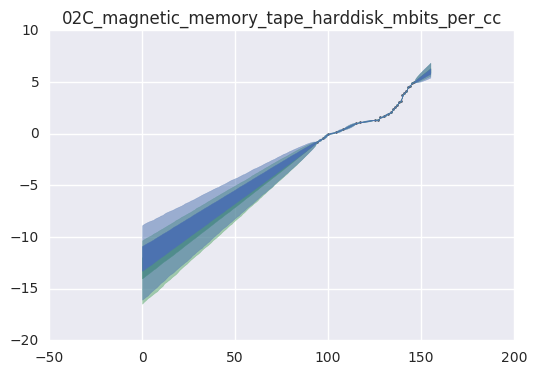

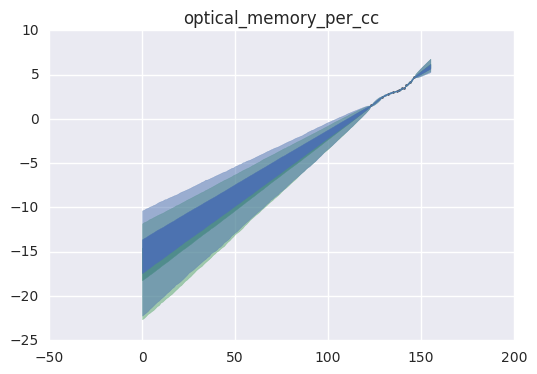

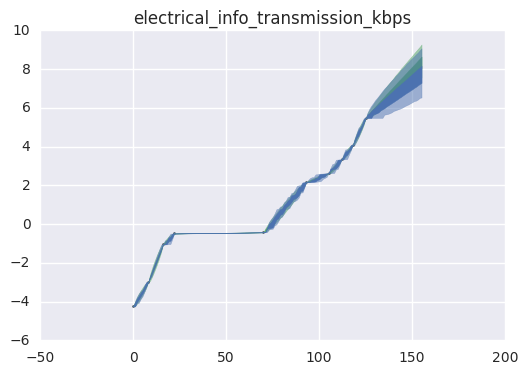

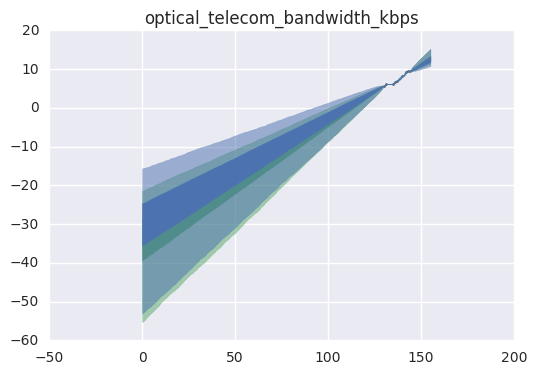

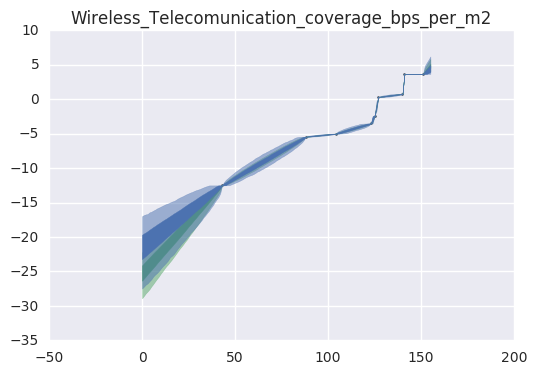

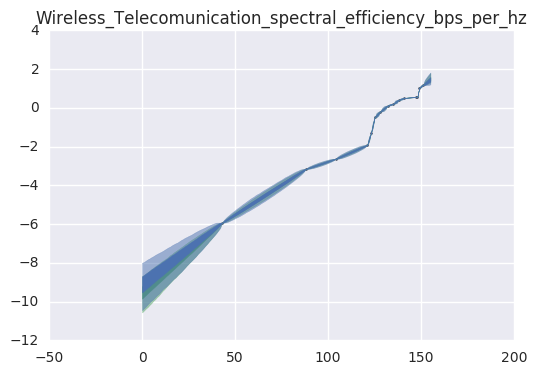

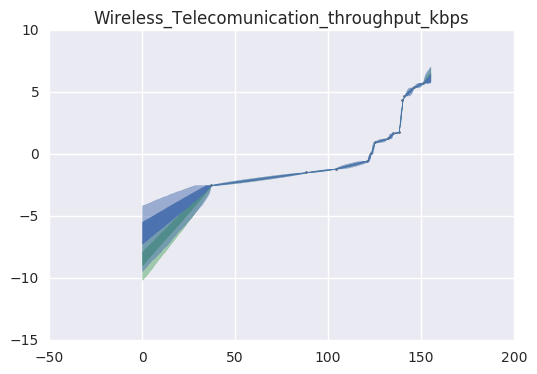

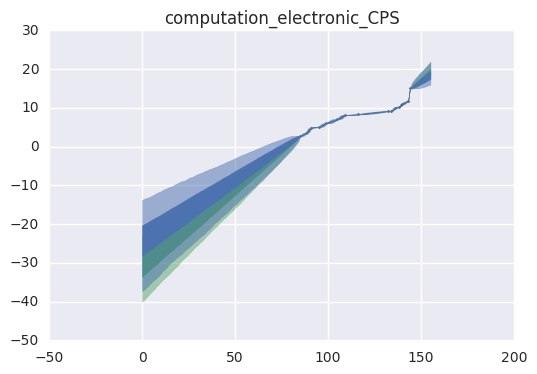

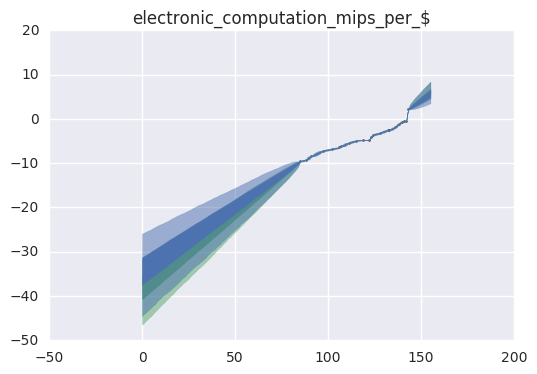

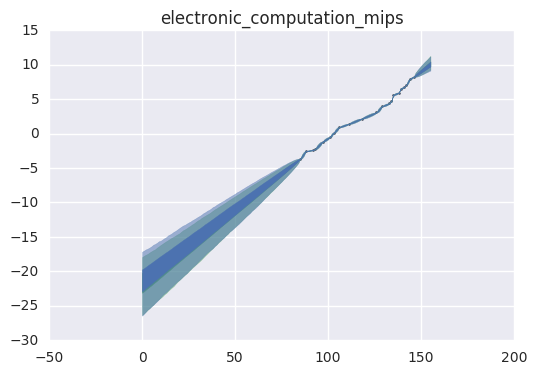

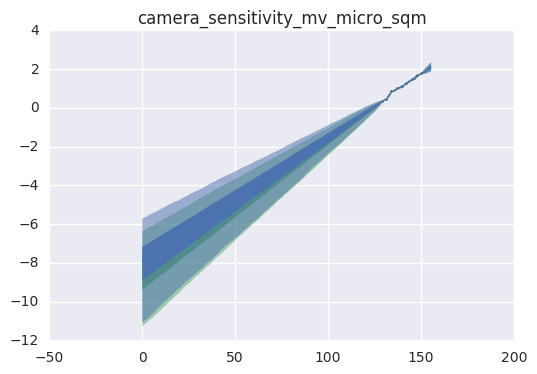

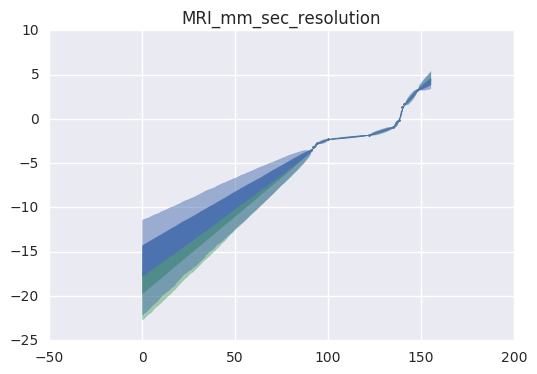

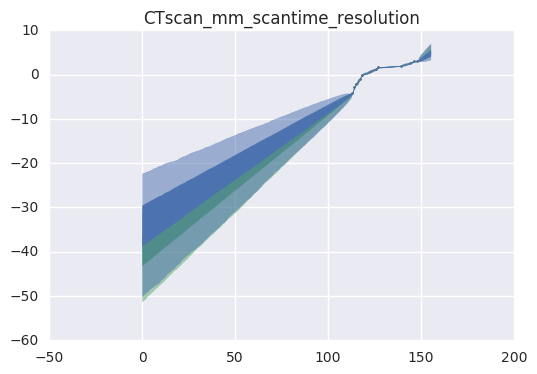

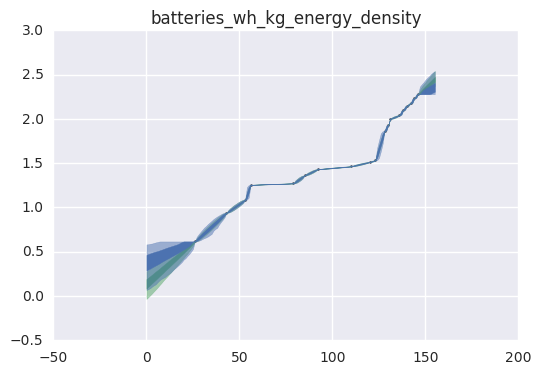

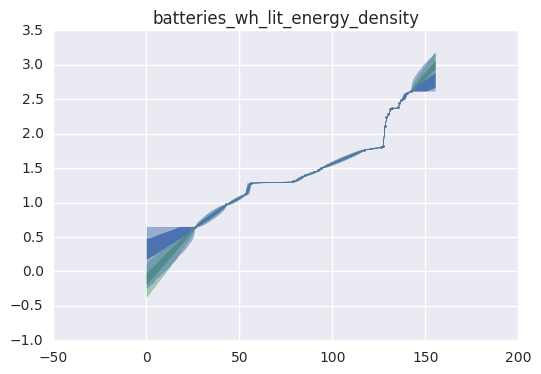

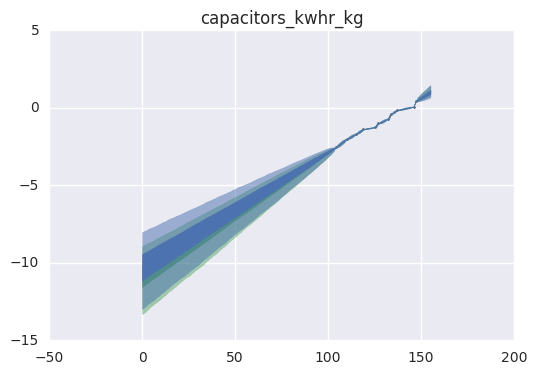

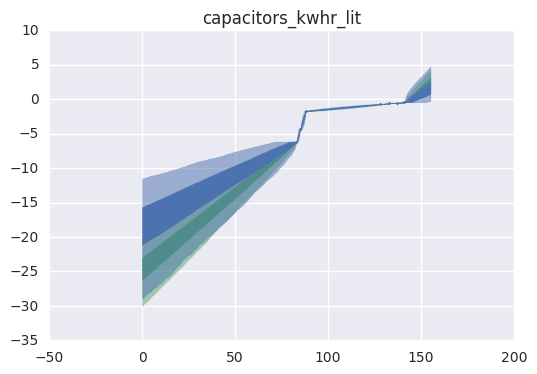

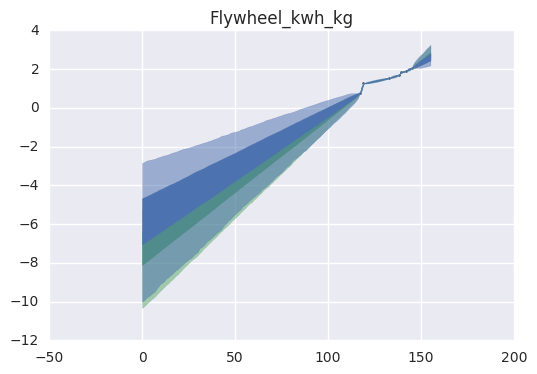

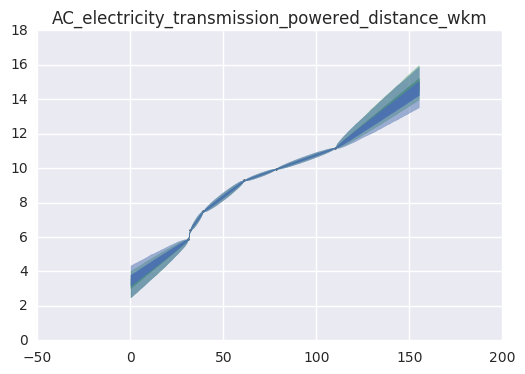

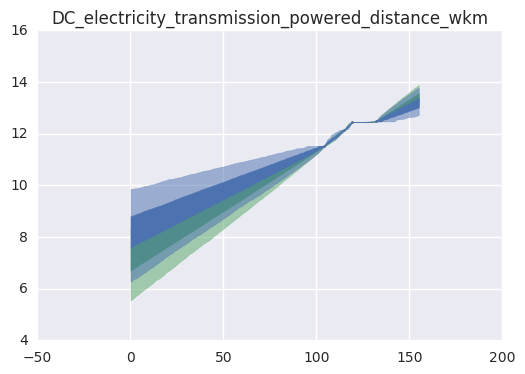

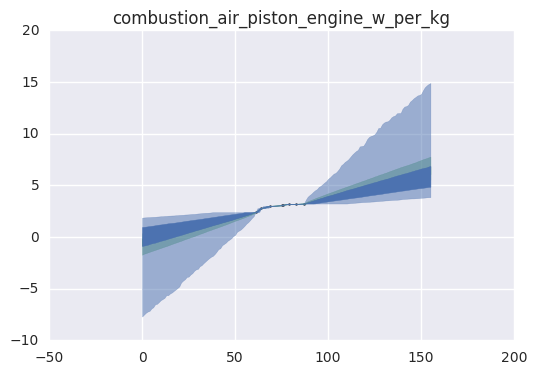

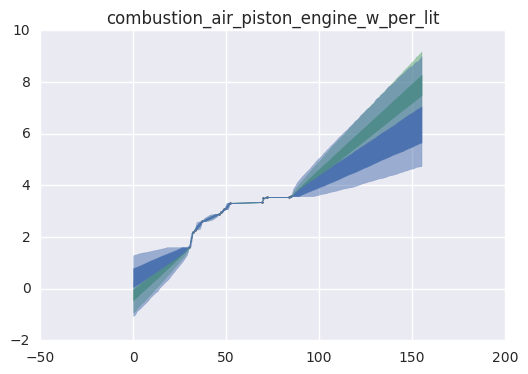

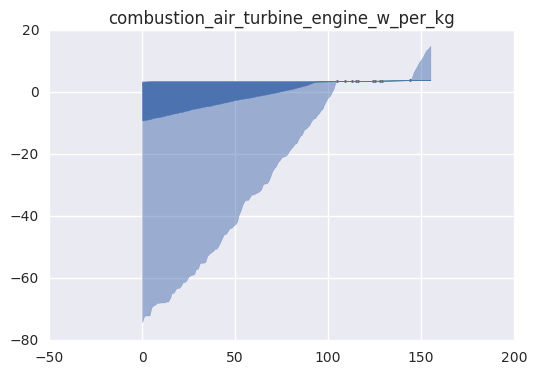

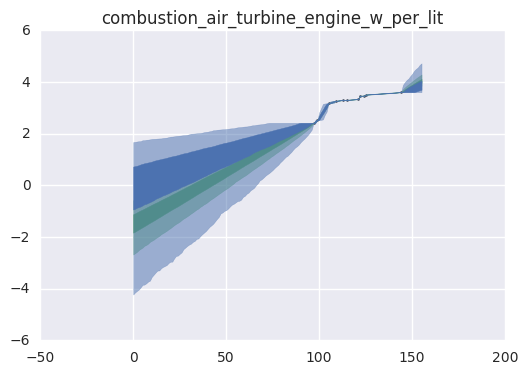

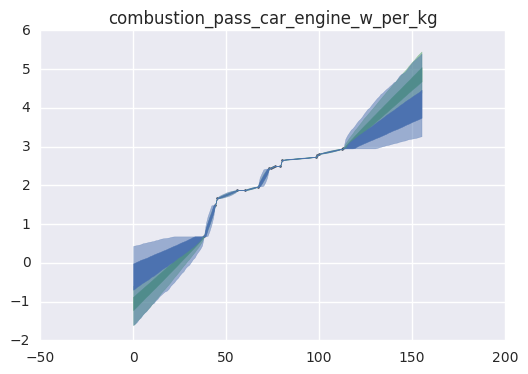

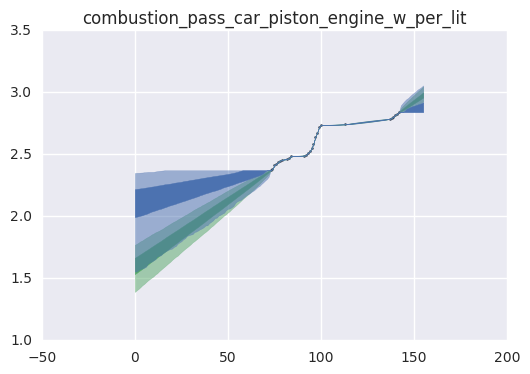

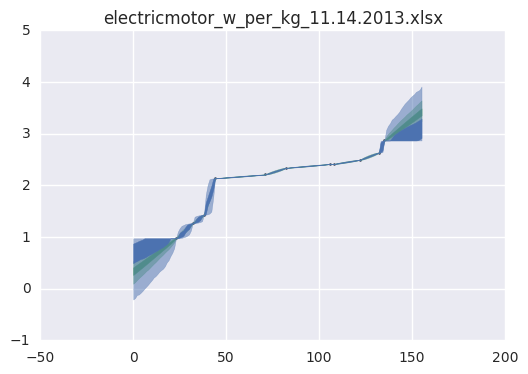

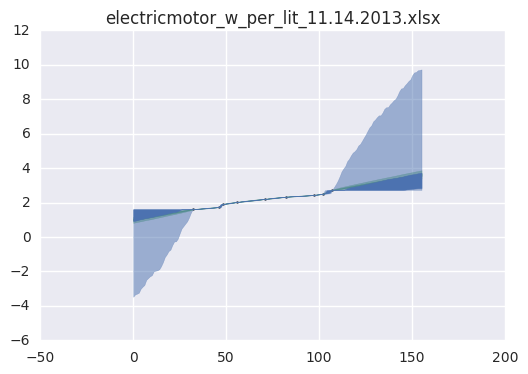

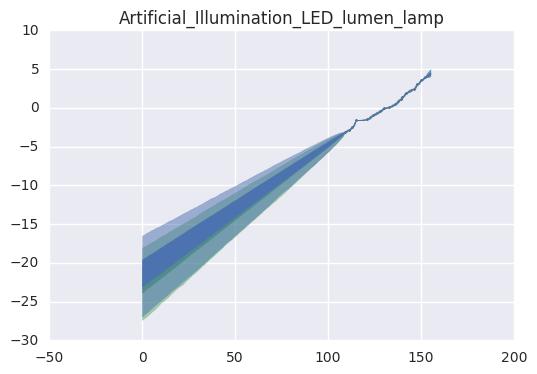

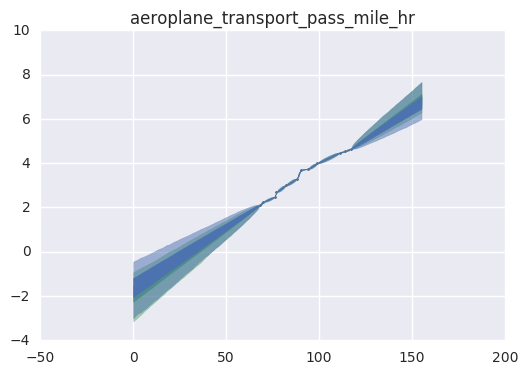

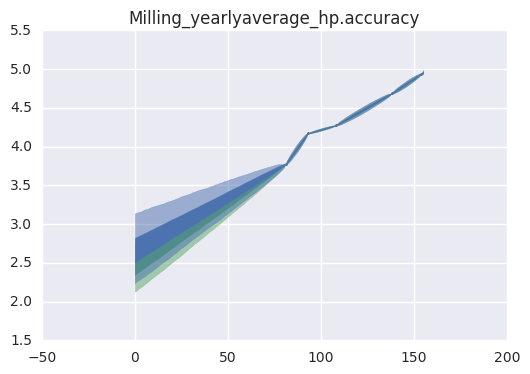

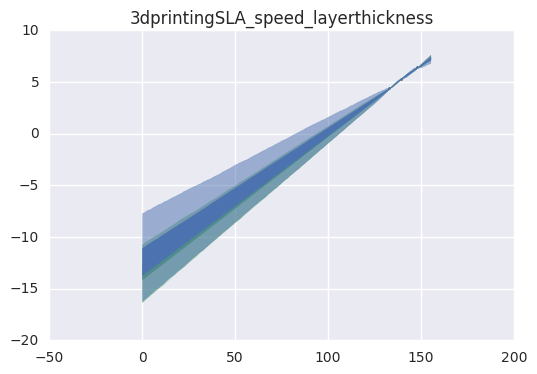

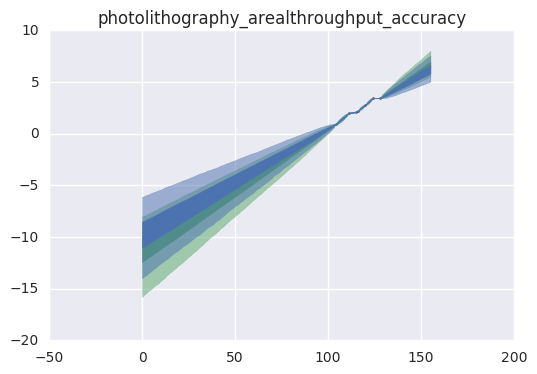

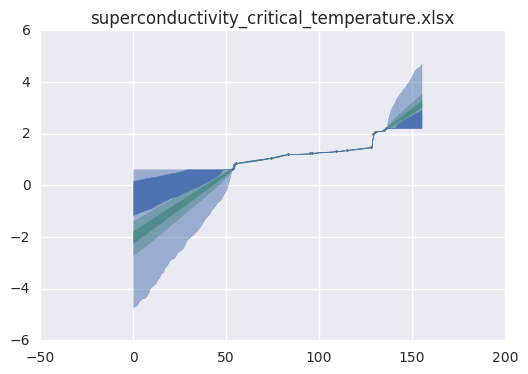

In [10]:
target_tech_names = metadata.ix[metadata['Type']=='Performance', 'Name']
print("%i technologies"%target_tech_names.shape[0])

technology_models['improvement~p(theta)N(mu,sigma)'] = pd.DataFrame(columns=['mu', 'sigma', 
                                                                             'theta', 
                                                                             'mean', 'variance',
                                                                             'mean_analytic', 'variance_analytic',
                                                                            'log_likelihood'], 
                                                                    index=target_tech_names)
technology_models['improvement~N(mu,sigma)'] = pd.DataFrame(columns=['mu', 'sigma', 
                                                                     'mean', 'variance',
                                                                    'mean_analytic', 'variance_analytic',
                                                                    'log_likelihood'], 
                                                            index=target_tech_names)

n_future_steps = 0
for tech_name in target_tech_names:
    print('------------------------------------')
    print(tech_name)
    print('------------------------------------')
    figure()
    title(tech_name)
    
    time_series = log10(data[tech_name]**-1)
    scatter(arange(len(time_series)), time_series,s=2)

    stan_data = {'N_time_periods': len(time_series),
            'N_time_periods_for_inference': len(time_series),
             'Y': pd.Series(concatenate((time_series,
                                         empty(n_future_steps)*nan),0)).fillna(-999),
            'mu_prior_location': .1,
            'mu_prior_scale': 2,
            'sigma_prior_location': 1,
            'sigma_prior_scale': 2}
    
    ###
    model_fit = stanity.fit(model_code['improvement~N(mu,sigma)'], data=stan_data, n_jobs=n_jobs)
    print(_print_stanfit(model_fit, ['mu', 'sigma']))
    technology_models['improvement~N(mu,sigma)'].ix[tech_name,'mu'] = model_fit['mu'].mean()
    technology_models['improvement~N(mu,sigma)'].ix[tech_name,'sigma'] = model_fit['sigma'].mean()
    technology_models['improvement~N(mu,sigma)'].ix[tech_name,'mean'] = model_fit['mean_change'].mean()
    technology_models['improvement~N(mu,sigma)'].ix[tech_name,'variance'] = model_fit['variance_change'].mean()
    technology_models['improvement~N(mu,sigma)'].ix[tech_name, 'mean_analytic'] = truncnorm(0, 10000, 
                                                         loc=model_fit['mu'].mean(), 
                                                         scale=model_fit['sigma'].mean()).mean()
    technology_models['improvement~N(mu,sigma)'].ix[tech_name, 'variance_analytic'] = truncnorm(0, 10000, 
                                                         loc=model_fit['mu'].mean(), 
                                                         scale=model_fit['sigma'].mean()).var()
    technology_models['improvement~N(mu,sigma)'].ix[tech_name,'log_likelihood'] = nanmean(model_fit['log_likelihood'])

    plot_time_series_inference(model_fit, color='g')
    
    ###
    stan_data['theta_prior_location'] = .5
    stan_data['theta_prior_scale'] = 2
    
    model_fit = stanity.fit(model_code['improvement~p(theta)N(mu,sigma)'], data=stan_data, n_jobs=n_jobs)
    print(_print_stanfit(model_fit, ['mu', 'sigma','theta']))
    technology_models['improvement~p(theta)N(mu,sigma)'].ix[tech_name,'mu'] = model_fit['mu'].mean()
    technology_models['improvement~p(theta)N(mu,sigma)'].ix[tech_name,'sigma'] = model_fit['sigma'].mean()
    technology_models['improvement~p(theta)N(mu,sigma)'].ix[tech_name,'theta'] = model_fit['theta'].mean()
    technology_models['improvement~p(theta)N(mu,sigma)'].ix[tech_name,'mean'] = model_fit['mean_change'].mean()
    technology_models['improvement~p(theta)N(mu,sigma)'].ix[tech_name,'variance'] = model_fit['variance_change'].mean()
    
    technology_models['improvement~p(theta)N(mu,sigma)'].ix[tech_name, 'mean_analytic'] = model_fit['theta'].mean() * truncnorm(0, 10000, 
                                                         loc=model_fit['mu'].mean(), 
                                                         scale=model_fit['sigma'].mean()).mean()
    technology_models['improvement~p(theta)N(mu,sigma)'].ix[tech_name, 'variance_analytic'] = model_fit['theta'].mean() * truncnorm(0, 10000, 
                                                         loc=model_fit['mu'].mean(), 
                                                         scale=model_fit['sigma'].mean()).var()
    technology_models['improvement~p(theta)N(mu,sigma)'].ix[tech_name,'log_likelihood'] = nanmean(model_fit['log_likelihood'])
        
    plot_time_series_inference(model_fit, color='b')

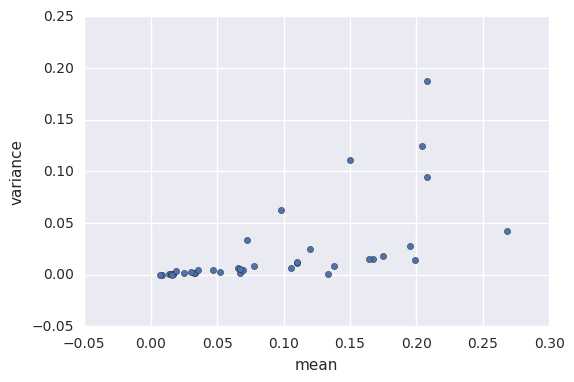

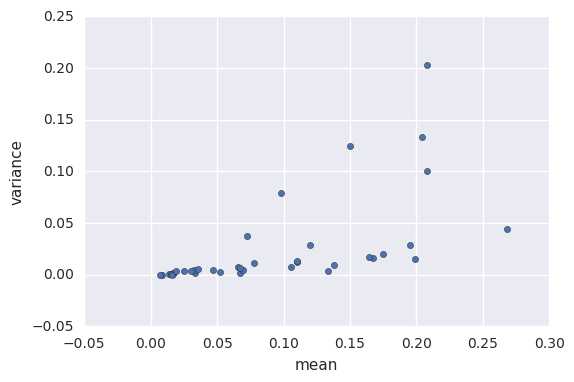

In [11]:
technology_models['improvement~N(mu,sigma)'].plot('mean', 'variance', kind='scatter')
figure()
technology_models['improvement~p(theta)N(mu,sigma)'].plot('mean', 'variance', kind='scatter')

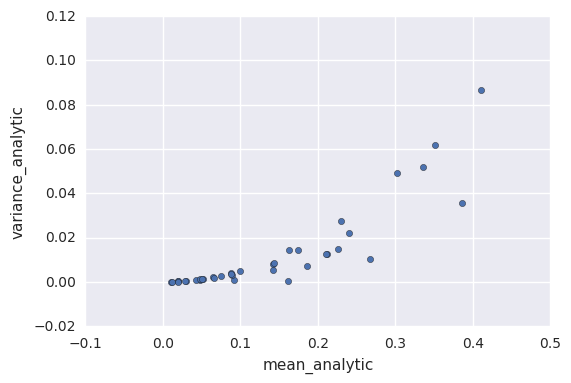

In [12]:
technology_models['improvement~N(mu,sigma)'].plot('mean_analytic', 'variance_analytic', kind='scatter')

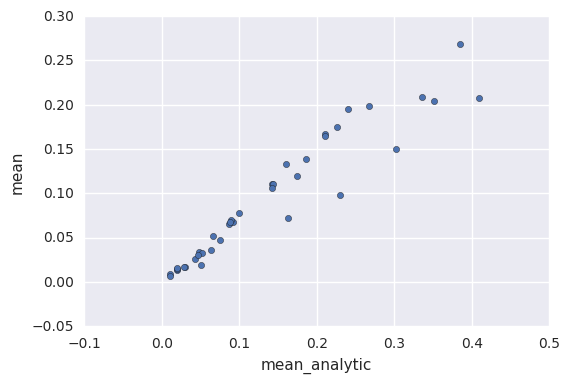

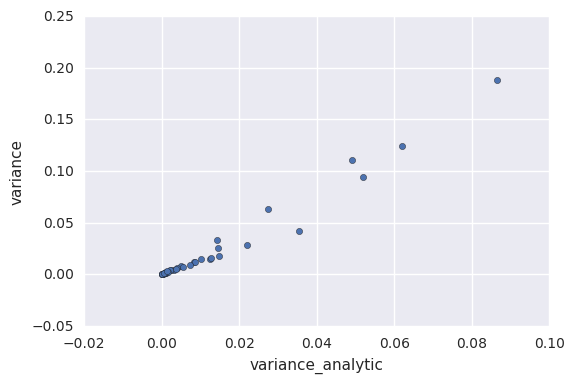

In [13]:
technology_models['improvement~N(mu,sigma)'].plot('mean_analytic', 'mean', kind='scatter')
figure()
technology_models['improvement~N(mu,sigma)'].plot('variance_analytic', 'variance', kind='scatter')

Fit all time series using data up until specific years, then predict future years
====

In [14]:
target_tech_names = metadata.ix[metadata['Type']=='Performance', 'Name']
print("%i technologies"%target_tech_names.shape[0])

training_years = arange(1950,2000,10)
horizons = [5,10,'all']

technology_models_prediction['improvement~p(theta)N(mu,sigma)'] = pd.Panel(items=target_tech_names,
         major_axis=horizons, 
         minor_axis=training_years)
technology_models_prediction['improvement~N(mu,sigma)'] = pd.Panel(items=target_tech_names,
         major_axis=horizons, 
         minor_axis=training_years)

first_year = data.index[0]
for tech_name in target_tech_names:
    print('------------------------------------')
    print(tech_name)
    print('------------------------------------')
    
    time_series = log10(data[tech_name]**-1)
    
    for training_year in training_years:
        print(training_year)
        
        start_ind = int(training_year-first_year)
        
        if sum(~isnan(time_series.values[:start_ind]))>2:            
            stan_data = {'N_time_periods': len(time_series),
                    'N_time_periods_for_inference': start_ind,
                     'Y': pd.Series(time_series).fillna(-999),
                    'mu_prior_location': .1,
                    'mu_prior_scale': 2,
                    'sigma_prior_location': 1,
                    'sigma_prior_scale': 2}

            ###
            model_fit = stanity.fit(model_code['improvement~N(mu,sigma)'], data=stan_data, n_jobs=n_jobs)
            print(_print_stanfit(model_fit, ['mu', 'sigma']))

            for horizon in horizons:
                if horizon=='all':
                    ll = nanmean(model_fit['log_likelihood'][:,start_ind:])
                else:
                    ll = nanmean(model_fit['log_likelihood'][:,start_ind:start_ind+horizon])
                technology_models_prediction['improvement~N(mu,sigma)'].ix[tech_name,horizon,training_year] = ll

            ###
            stan_data['theta_prior_location'] = .5
            stan_data['theta_prior_scale'] = 2
            
            model_fit = stanity.fit(model_code['improvement~p(theta)N(mu,sigma)'], data=stan_data, n_jobs=n_jobs)
            print(_print_stanfit(model_fit, ['mu', 'sigma', 'theta']))

            for horizon in horizons:
                if horizon=='all':
                    ll = nanmean(model_fit['log_likelihood'][:,start_ind:])
                else:
                    ll = nanmean(model_fit['log_likelihood'][:,start_ind:start_ind+horizon])
                technology_models_prediction['improvement~p(theta)N(mu,sigma)'].ix[tech_name,horizon,training_year] = ll

38 technologies
------------------------------------
integrated_circuit_memory_transistors_per_die
------------------------------------
1950
1960
1970
Reusing model.
Ran in 0.972 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.25  2.7e-3   0.09   0.03   0.21   0.27    0.3    0.4   1105    1.0
sigma   0.18  5.1e-3   0.15   0.05   0.09   0.13   0.23   0.56    908    1.0

Samples were drawn using NUTS at Sat Nov 12 06:28:39 2016.

Reusing model.
Ran in 1.079 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.25  3.0e-3    0.1   0.03   0.21   0.27   0.31   0.43   1100    1.0
sigma   0.19  6.6e-3   0.16   0.05   0.09   0.14   0.25   0.62    575   1.01
theta   0.86  3.2e-3   0

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.863 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  9.3e-4   0.03 4.4e-3   0.04   0.07   0.09   0.11    989   1.01
sigma   0.07  7.7e-4   0.02   0.03   0.05   0.07   0.08   0.12    947   1.01
theta   0.88  2.4e-3    0.1   0.64   0.83   0.91   0.96    1.0   1601    1.0

Samples were drawn using NUTS at Sat Nov 12 06:29:04 2016.

1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.447 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.04  4.6e-4   0.02 1.7e-3   0.02   0.04   0.05   0.07   1858    1.0
sigma   0.07  3.7e-4   0.01   0.04   0.06   0.07   0.08    0.1   1609    1.0

Samples were drawn using NUTS at Sat Nov 12 06:29:05 2016.

Reusing model.
Ran in 2.174 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.05  8.6e-4   0.02 4.4e-3   0.03   0.05   0.06   0.09    747    1.0
sigma   0.07  6.5e-4   0.02   0.04   0.05   0.06   0.08    0.1    670   1.01
theta    0.9  3.3e-3   0.09   0.68   0.85   0.92   0.97    1.0    699   1.01

Samples were drawn using NUTS at Sat Nov 12 06:29:07 2016.

------------------------------------
02B_magnetic_me

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 11.472 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.22    0.01   0.02   0.19   0.21   0.22   0.23   0.26      3   2.42
sigma   0.04  1.5e-3 9.4e-3   0.03   0.03   0.04   0.04   0.06     41   1.12
theta   0.34    0.02   0.05   0.25   0.31   0.34   0.38   0.44      7   1.17

Samples were drawn using NUTS at Sat Nov 12 06:30:45 2016.

------------------------------------
optical_telecom_bandwidth_kbps
------------------------------------
1950
1960
1970
1980
1990
------------------------------------
Wireless_Telecomunication_coverage_bps_per_m2
------------------------------------
1950
1960
1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.069 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.05  8.7e-4   0.03 2.7e-3   0.03   0.05   0.08   0.11   1356    1.0
sigma   0.13  5.7e-4   0.02   0.09   0.11   0.13   0.14   0.17   1468    1.0

Samples were drawn using NUTS at Sat Nov 12 06:30:48 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 18.581 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.17  8.3e-3   0.02   0.11   0.17   0.18   0.18   0.18      6   1.25
sigma   0.02    0.02   0.03 7.7e-4 2.2e-3 8.6e-3   0.03   0.11      3   1.72
theta    0.7    0.03   0.08   0.57   0.64   0.68   0.74   0.87      8   1.17

Samples were drawn using NUTS at Sat Nov 12 06:31:06 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.194 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  7.6e-4   0.03 3.6e-3   0.03   0.06   0.08   0.11   1716    1.0
sigma   0.13  5.3e-4   0.02   0.09   0.11   0.13   0.14   0.17   1577    1.0

Samples were drawn using NUTS at Sat Nov 12 06:31:10 2016.

Reusing model.
Ran in 10.578 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.17    0.02   0.03   0.08   0.16   0.16   0.19    0.2      4   1.34
sigma   0.03    0.02   0.03 4.8e-4 3.4e-3   0.02   0.04   0.13      3   1.62
theta   0.72    0.06    0.1   0.55   0.63   0.73   0.81   0.92      3   1.49

Samples were drawn using NUTS at Sat Nov 12 06:31:20 2016.

1990
Reusing model.
Ran in 3.560 sec.
4 chains, eac

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 8.176 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.03  4.8e-4   0.03 7.8e-4 9.1e-3   0.02   0.04   0.11   4000    1.0
sigma   0.34  6.3e-4   0.04   0.27   0.31   0.34   0.37   0.43   4000    1.0
theta   0.67  3.0e-3   0.08   0.51   0.62   0.68   0.73   0.83    727   1.01

Samples were drawn using NUTS at Sat Nov 12 06:31:32 2016.

------------------------------------
Wireless_Telecomunication_spectral_efficiency_bps_per_hz
------------------------------------
1950
1960
1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.858 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.05  7.2e-5 3.4e-3   0.05   0.05   0.05   0.06   0.06   2268    1.0
sigma   0.02  1.1e-4 4.1e-3   0.02   0.02   0.02   0.03   0.03   1303    1.0

Samples were drawn using NUTS at Sat Nov 12 06:31:35 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 17.387 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  9.9e-4 1.4e-3   0.06   0.06   0.06   0.06   0.07      2    nan
sigma 7.6e-4  1.9e-4 7.6e-4 1.1e-4 2.3e-4 5.2e-4 1.0e-3 3.0e-3     16    nan
theta   0.83    0.02   0.05   0.73    0.8   0.84   0.87   0.91      8   1.14

Samples were drawn using NUTS at Sat Nov 12 06:31:53 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.583 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.05  4.4e-5 2.8e-3   0.04   0.05   0.05   0.05   0.06   4000    1.0
sigma   0.02  8.5e-5 3.4e-3   0.02   0.02   0.02   0.02   0.03   1537    1.0

Samples were drawn using NUTS at Sat Nov 12 06:31:56 2016.

Reusing model.
Ran in 46.165 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  1.9e-3 2.6e-3   0.06   0.06   0.06   0.07   0.07      2    nan
sigma 8.9e-4  2.9e-4 8.6e-4 1.2e-4 3.3e-4 6.4e-4 1.1e-3 3.3e-3      9    nan
theta   0.78    0.03   0.06   0.66   0.74   0.79   0.83   0.88      4   1.31

Samples were drawn using NUTS at Sat Nov 12 06:32:43 2016.

1990
Reusing model.
Ran in 4.073 sec.
4 chains, eac

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 25.092 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.02  8.0e-5 3.3e-4   0.02   0.02   0.02   0.02   0.02     17    nan
sigma 2.3e-4  1.6e-5 1.7e-4 5.6e-5 1.1e-4 1.7e-4 3.0e-4 6.8e-4    109    nan
theta   0.93  6.8e-3   0.04   0.84    0.9   0.93   0.95   0.99     30   1.11

Samples were drawn using NUTS at Sat Nov 12 06:33:21 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.572 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.02  5.6e-5 2.0e-3   0.02   0.02   0.02   0.02   0.03   1246    1.0
sigma   0.01  6.7e-5 2.1e-3 9.5e-3   0.01   0.01   0.01   0.02    953    1.0

Samples were drawn using NUTS at Sat Nov 12 06:33:25 2016.

Reusing model.
Ran in 122.195 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.04  1.0e-4 4.5e-4   0.04   0.04   0.04   0.04   0.04     20    nan
sigma 3.9e-4  3.9e-5 3.2e-4 3.0e-5 1.7e-4 3.1e-4 5.1e-4 1.2e-3     70    nan
theta   0.53  3.2e-3   0.05   0.42    0.5   0.53   0.57   0.64    289   1.02

Samples were drawn using NUTS at Sat Nov 12 06:35:27 2016.

1990
Reusing model.
Ran in 4.386 sec.
4 chains, ea

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.557 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.11  2.0e-3   0.08 4.1e-3   0.05    0.1   0.16   0.29   1561    1.0
sigma   0.27  1.8e-3   0.07   0.16   0.22   0.26   0.31   0.42   1298    1.0
theta   0.73  4.0e-3   0.11   0.49   0.65   0.73   0.81   0.93    779    1.0

Samples were drawn using NUTS at Sat Nov 12 06:35:51 2016.

1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.491 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.05  8.0e-4   0.04 1.9e-3   0.02   0.04   0.07   0.14   2287    1.0
sigma   0.24  8.2e-4   0.04   0.17   0.21   0.23   0.26   0.32   2168    1.0

Samples were drawn using NUTS at Sat Nov 12 06:35:52 2016.

Reusing model.
Ran in 2.774 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.11  2.2e-3   0.08 3.9e-3   0.05    0.1   0.16   0.28   1305    1.0
sigma   0.27  1.9e-3   0.06   0.16   0.22   0.26    0.3   0.41   1108    1.0
theta   0.73  4.8e-3   0.12   0.48   0.65   0.74   0.81   0.94    588   1.01

Samples were drawn using NUTS at Sat Nov 12 06:35:55 2016.

------------------------------------
electronic_comp

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.778 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.21    0.01   0.18   0.01   0.11   0.19   0.27   0.63    272   1.01
sigma   0.31    0.03   0.45   0.06   0.13   0.22   0.34    1.2    199   1.02
theta   0.75    0.01   0.19   0.28   0.63   0.79    0.9   0.99    175   1.01

Samples were drawn using NUTS at Sat Nov 12 06:35:57 2016.

1960
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.853 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.16  2.1e-3   0.06   0.02   0.13   0.18   0.21   0.25    806    1.0
sigma   0.13  2.8e-3   0.06   0.05   0.08   0.12   0.17   0.29    539    1.0

Samples were drawn using NUTS at Sat Nov 12 06:35:58 2016.

Reusing model.
Ran in 2.666 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.25    0.06    0.1   0.05   0.19   0.22   0.38    0.4      3   1.98
sigma   0.09    0.03   0.09 2.6e-3   0.03   0.07   0.12   0.31      6   1.22
theta   0.78    0.11   0.18   0.35   0.67   0.83   0.93   0.99      3   1.61

Samples were drawn using NUTS at Sat Nov 12 06:36:00 2016.

1970
Reusing model.
Ran in 1.962 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.162 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.12  2.7e-3   0.07 4.4e-3   0.06   0.12   0.18   0.26    776   1.01
sigma   0.21  2.0e-3   0.06   0.12   0.17   0.21   0.25   0.34    865    1.0
theta   0.87  3.6e-3   0.09   0.64   0.82   0.89   0.95   0.99    673    1.0

Samples were drawn using NUTS at Sat Nov 12 06:36:21 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.766 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.07  1.2e-3   0.05 2.8e-3   0.03   0.06    0.1   0.17   1617    1.0
sigma    0.2  7.7e-4   0.04   0.14   0.17    0.2   0.22   0.28   2163    1.0

Samples were drawn using NUTS at Sat Nov 12 06:36:23 2016.

Reusing model.
Ran in 2.259 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.09  1.6e-3   0.06 4.6e-3   0.04   0.09   0.14   0.22   1377    1.0
sigma    0.2  1.2e-3   0.04   0.13   0.17    0.2   0.23    0.3   1431    1.0
theta    0.9  2.6e-3   0.08    0.7   0.85   0.91   0.96    1.0    952    1.0

Samples were drawn using NUTS at Sat Nov 12 06:36:26 2016.

1990
Reusing model.
Ran in 2.259 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.155 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.12  2.8e-3   0.08 7.4e-3   0.06   0.12   0.18   0.29    807    1.0
sigma   0.19  4.3e-3    0.1   0.07   0.12   0.17   0.22   0.44    501   1.01
theta   0.75  6.3e-3   0.17   0.38   0.64   0.77   0.89   0.99    731    1.0

Samples were drawn using NUTS at Sat Nov 12 06:36:33 2016.

1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.658 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.08  1.0e-3   0.05 3.1e-3   0.04   0.07   0.12   0.19   2602    1.0
sigma   0.17  1.4e-3   0.06   0.09   0.13   0.16    0.2   0.33   2047    1.0

Samples were drawn using NUTS at Sat Nov 12 06:36:34 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.950 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.13  3.5e-3   0.09 6.7e-3   0.06   0.11   0.18   0.31    659   1.01
sigma   0.19  4.1e-3   0.12   0.06   0.12   0.17   0.23   0.47    787   1.01
theta   0.74    0.01   0.18   0.35   0.63   0.78   0.88   0.99    281   1.01

Samples were drawn using NUTS at Sat Nov 12 06:36:35 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.566 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.08  1.1e-3   0.05 2.7e-3   0.03   0.07   0.11   0.19   2467    1.0
sigma   0.18  1.3e-3   0.06   0.09   0.13   0.16    0.2   0.33   2137    1.0

Samples were drawn using NUTS at Sat Nov 12 06:36:35 2016.

Reusing model.
Ran in 1.058 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.13  4.4e-3   0.09 4.6e-3   0.06   0.12   0.18    0.3    384   1.01
sigma   0.19  4.7e-3   0.12   0.05   0.12   0.16   0.22   0.48    595    1.0
theta   0.74  8.8e-3   0.17   0.36   0.63   0.77   0.88   0.99    387   1.01

Samples were drawn using NUTS at Sat Nov 12 06:36:37 2016.

1990
Reusing model.
Ran in 1.156 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.254 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.23  4.2e-3   0.18 7.7e-3   0.08   0.19   0.33   0.64   1784    1.0
sigma   0.62  4.6e-3   0.18   0.37    0.5   0.59   0.71   1.07   1453    1.0
theta   0.83  3.9e-3   0.12   0.55   0.76   0.85   0.93   0.99    972    1.0

Samples were drawn using NUTS at Sat Nov 12 06:36:44 2016.

------------------------------------
batteries_wh_kg_energy_density
------------------------------------
1950
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.756 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    1.7e-3  2.4e-5 1.5e-3 4.4e-5 5.3e-4 1.3e-3 2.5e-3 5.5e-3   4000    1.0
sigma   0.02  3.4e-5 2.0e-3   0.02   0.02   0.02   0.02   0.02   3401    1.0

Samples were drawn using NUTS at Sat Nov 12 06:36:46 2016.

Reusing model.
Ran in 6.056 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.07    0.03   0.29 8.6e-4 8.2e-3   0.02   0.03   0.81     75   1.03
sigma   0.17    0.08   0.64   0.01   0.02   0.03   0.04   1.84     69   1.04
theta   0.26    0.01   0.13   0.02   0.17   0.25   0.33   0.54    154   1.02

Samples were drawn using NUTS at Sat Nov 12 06:36:52 2016.

1960
Reusing model.
Ran in 2.760 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 6.367 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.18    0.04    0.5 7.3e-4 9.0e-3   0.02   0.05   1.78    149   1.02
sigma   0.42    0.09   1.22   0.02   0.03   0.04   0.08   3.28    165   1.02
theta   0.19    0.01   0.13 9.3e-3   0.08   0.19   0.28   0.47    117   1.02

Samples were drawn using NUTS at Sat Nov 12 06:37:01 2016.

1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.594 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    9.0e-4  1.4e-5 8.6e-4 2.3e-5 2.8e-4 6.5e-4 1.3e-3 3.2e-3   4000    nan
sigma   0.02  2.2e-5 1.4e-3   0.01   0.02   0.02   0.02   0.02   3804    1.0

Samples were drawn using NUTS at Sat Nov 12 06:37:05 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 6.067 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.55    0.04   0.78 3.5e-3   0.04    0.2   0.78   2.75    330   1.01
sigma   1.46    0.11   2.63   0.02   0.07   0.63   1.85   7.63    573   1.01
theta   0.05  6.4e-3   0.06 3.7e-3   0.02   0.03   0.07   0.22     93   1.06

Samples were drawn using NUTS at Sat Nov 12 06:37:11 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.775 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    7.5e-4  1.1e-5 7.3e-4 1.7e-5 2.3e-4 5.4e-4 1.1e-3 2.7e-3   4000    nan
sigma   0.02  1.8e-5 1.2e-3   0.01   0.01   0.02   0.02   0.02   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:37:15 2016.

Reusing model.
Ran in 7.382 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.69    0.01    0.8 8.0e-3   0.11    0.4   0.97   2.98   4000    1.0
sigma   1.76    0.06   2.57   0.03   0.35   1.07   2.26   7.74   1954    1.0
theta   0.03  2.5e-3   0.03 2.9e-3   0.01   0.02   0.04   0.14    173   1.01

Samples were drawn using NUTS at Sat Nov 12 06:37:22 2016.

1990
Reusing model.
Ran in 3.872 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 9.281 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.07    0.02   0.28 6.2e-4 6.8e-3   0.02   0.03   0.75    165   1.02
sigma   0.18    0.06    1.1   0.02   0.02   0.03   0.04   1.92    337   1.01
theta   0.27  8.6e-3   0.13   0.02   0.18   0.26   0.35   0.54    232   1.01

Samples were drawn using NUTS at Sat Nov 12 06:37:56 2016.

1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.893 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    1.6e-3  2.3e-5 1.4e-3 5.3e-5 5.5e-4 1.3e-3 2.4e-3 5.3e-3   4000    1.0
sigma   0.02  3.3e-5 1.7e-3   0.02   0.02   0.02   0.02   0.02   2818    1.0

Samples were drawn using NUTS at Sat Nov 12 06:37:59 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 5.864 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.03  6.0e-3   0.11 5.7e-4 6.5e-3   0.01   0.03   0.06    350   1.01
sigma   0.06    0.02   0.28   0.01   0.02   0.03   0.04   0.09    279   1.01
theta   0.28  4.4e-3   0.12   0.07   0.19   0.27   0.35   0.55    749    1.0

Samples were drawn using NUTS at Sat Nov 12 06:38:05 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.766 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    1.5e-3  2.1e-5 1.3e-3 3.2e-5 4.9e-4 1.1e-3 2.2e-3 4.9e-3   4000    1.0
sigma   0.02  2.3e-5 1.4e-3   0.01   0.02   0.02   0.02   0.02   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:38:09 2016.

Reusing model.
Ran in 7.770 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       0.2    0.05   0.53 5.8e-4 6.5e-3   0.02   0.04   1.98    110   1.02
sigma   0.57    0.15   2.56   0.02   0.02   0.03   0.08   4.52    311   1.01
theta    0.2    0.01   0.15 6.6e-3   0.06    0.2   0.31    0.5     95   1.02

Samples were drawn using NUTS at Sat Nov 12 06:38:17 2016.

1990
Reusing model.
Ran in 4.166 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.850 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.84    0.01    0.3   0.09    0.8   0.88   0.93   1.45    495   1.01
sigma   0.47    0.07    0.6   0.04   0.09   0.21   0.66    2.1     78   1.03
theta   0.83    0.01   0.15   0.44   0.76   0.88   0.95   0.99    133   1.02

Samples were drawn using NUTS at Sat Nov 12 06:38:37 2016.

1960
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.456 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.82    0.01   0.24   0.15   0.78   0.88   0.92   1.21    434   1.01
sigma    0.4    0.09   0.47   0.03    0.1   0.22   0.55   1.66     29   1.11

Samples were drawn using NUTS at Sat Nov 12 06:38:38 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.660 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.85    0.02   0.34    0.1   0.77   0.88   0.94   1.63    235    1.0
sigma   0.52    0.09   0.63   0.07    0.1   0.24   0.74   2.14     53   1.07
theta   0.84    0.03   0.15   0.43   0.77   0.88   0.95   0.99     27   1.08

Samples were drawn using NUTS at Sat Nov 12 06:38:38 2016.

1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.447 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.82    0.01   0.24   0.15   0.79   0.88   0.92   1.18    523   1.01
sigma   0.39    0.04   0.45   0.06    0.1    0.2   0.52   1.63    105   1.04

Samples were drawn using NUTS at Sat Nov 12 06:38:39 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.851 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.87    0.02   0.29   0.19   0.82   0.89   0.93    1.6    327   1.01
sigma   0.43    0.08   0.56   0.03   0.08   0.17   0.59   1.96     53   1.07
theta   0.84    0.02   0.14   0.47   0.79   0.87   0.93   0.99     80   1.04

Samples were drawn using NUTS at Sat Nov 12 06:38:40 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.955 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.81  9.6e-3   0.24   0.14   0.78   0.87   0.92   1.17    645    1.0
sigma   0.39    0.03   0.47   0.04   0.09   0.18   0.53   1.69    205   1.02

Samples were drawn using NUTS at Sat Nov 12 06:38:41 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.257 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.84    0.02   0.35   0.11    0.7   0.88   0.97   1.62    415   1.02
sigma   0.64    0.05   0.68   0.06   0.19   0.43   0.91   2.23    172   1.02
theta   0.81    0.01   0.16   0.41   0.74   0.85   0.93   0.99    183   1.02

Samples were drawn using NUTS at Sat Nov 12 06:38:42 2016.

1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.454 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.02  2.4e-4   0.02 4.1e-4 4.6e-3   0.01   0.02   0.06   4000    1.0
sigma   0.32  6.0e-4   0.04   0.25   0.29   0.31   0.34    0.4   3601    1.0

Samples were drawn using NUTS at Sat Nov 12 06:38:44 2016.

Reusing model.
Ran in 4.954 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.11  2.4e-3    0.1 4.0e-3   0.04   0.09   0.16   0.38   1848    1.0
sigma   0.61    0.01   0.17   0.39    0.5   0.58   0.69   1.03    195   1.02
theta   0.35  2.9e-3   0.08    0.2   0.29   0.35   0.41   0.53    846    1.0

Samples were drawn using NUTS at Sat Nov 12 06:38:49 2016.

------------------------------------
Flywheel_kwh_kg

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.965 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.02  3.8e-4   0.02 8.1e-4 8.4e-3   0.02   0.03   0.08   2972    1.0
sigma   0.14  5.1e-4   0.02    0.1   0.12   0.13   0.15   0.18   1530    1.0
theta   0.84  3.3e-3    0.1   0.61   0.78   0.85   0.92   0.99    945    1.0

Samples were drawn using NUTS at Sat Nov 12 06:38:54 2016.

1960
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.151 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.02  2.2e-4   0.01 4.7e-4 5.4e-3   0.01   0.02   0.05   4000    1.0
sigma   0.12  2.4e-4   0.01    0.1   0.11   0.12   0.13   0.15   3323    1.0

Samples were drawn using NUTS at Sat Nov 12 06:38:56 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.762 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.02  3.7e-4   0.02 6.5e-4 7.8e-3   0.02   0.04   0.08   3306    1.0
sigma   0.14  4.7e-4   0.02    0.1   0.12   0.13   0.15   0.18   1926    1.0
theta   0.84  2.8e-3    0.1   0.61   0.78   0.85   0.92   0.99   1243    1.0

Samples were drawn using NUTS at Sat Nov 12 06:38:59 2016.

1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.274 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    7.8e-3  1.1e-4 7.1e-3 3.0e-4 2.4e-3 5.8e-3   0.01   0.03   4000    1.0
sigma    0.1  1.5e-4 8.3e-3   0.08   0.09    0.1    0.1   0.12   3041    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:02 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 4.877 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.01  1.7e-4   0.01 3.4e-4 3.9e-3 8.6e-3   0.02   0.04   4000    1.0
sigma   0.11  2.4e-4   0.01   0.09    0.1   0.11   0.12   0.14   2429    1.0
theta   0.85  2.1e-3   0.08   0.67   0.79   0.86   0.91   0.98   1647    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:07 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.957 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    7.8e-3  1.1e-4 7.1e-3 2.6e-4 2.5e-3 5.8e-3   0.01   0.03   4000    1.0
sigma    0.1  1.5e-4 8.3e-3   0.08   0.09    0.1    0.1   0.12   3058    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:10 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 4.359 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.01  1.7e-4   0.01 3.6e-4 3.8e-3 8.7e-3   0.02   0.04   4000    1.0
sigma   0.11  1.9e-4   0.01   0.09    0.1   0.11   0.12   0.14   4000    1.0
theta   0.85  2.1e-3   0.08   0.66    0.8   0.86   0.92   0.99   1599    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:15 2016.

1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.773 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    7.7e-3  1.1e-4 7.0e-3 2.3e-4 2.3e-3 5.6e-3   0.01   0.03   4000    1.0
sigma    0.1  1.4e-4 8.5e-3   0.08   0.09    0.1   0.11   0.12   3737    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:17 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 4.058 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.01  1.6e-4   0.01 3.0e-4 3.6e-3 8.4e-3   0.02   0.04   4000    1.0
sigma   0.11  3.0e-4   0.01   0.09    0.1   0.11   0.12   0.14   1739    1.0
theta   0.85  2.5e-3   0.08   0.67    0.8   0.86   0.92   0.98   1106    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:22 2016.

------------------------------------
DC_electricity_transmission_powered_distance_wkm
------------------------------------
1950
1960
1970
1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.854 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  7.5e-4 7.9e-3   0.04   0.06   0.06   0.06   0.07    111   1.03
sigma   0.02  8.6e-4   0.01 7.4e-3   0.01   0.01   0.02   0.05    158   1.02

Samples were drawn using NUTS at Sat Nov 12 06:39:23 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.462 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.07  8.9e-4 6.6e-3   0.06   0.07   0.07   0.07   0.09     55   1.07
sigma 7.2e-3  7.9e-4 8.0e-3 8.2e-4 2.6e-3 4.7e-3 9.2e-3   0.03    105   1.03
theta   0.83  9.1e-3   0.11   0.53   0.77   0.85   0.91   0.99    147   1.01

Samples were drawn using NUTS at Sat Nov 12 06:39:26 2016.

1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.460 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  4.4e-4 7.7e-3   0.04   0.06   0.06   0.06   0.07    305   1.02
sigma   0.02  6.0e-4   0.01 7.3e-3   0.01   0.01   0.02   0.05    302   1.02

Samples were drawn using NUTS at Sat Nov 12 06:39:28 2016.

Reusing model.
Ran in 3.272 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.07  3.8e-4 5.0e-3   0.06   0.07   0.07   0.07   0.07    176   1.02
sigma 7.9e-3  5.8e-4 7.2e-3 1.0e-3 3.1e-3 6.0e-3   0.01   0.03    152   1.02
theta   0.84  5.1e-3   0.09   0.63   0.79   0.85   0.91   0.99    336   1.01

Samples were drawn using NUTS at Sat Nov 12 06:39:31 2016.

------------------------------------
combustion_air_

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.879 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       0.1  3.3e-3    0.1 3.4e-3   0.04   0.08   0.13   0.33    956    1.0
sigma   0.19  9.6e-3   0.21   0.04   0.09   0.13   0.21   0.74    471   1.01
theta   0.25  3.8e-3    0.1   0.08   0.17   0.24   0.31   0.46    700   1.01

Samples were drawn using NUTS at Sat Nov 12 06:39:35 2016.

1960
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.166 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    7.2e-3  1.0e-4 6.3e-3 1.9e-4 2.4e-3 5.5e-3   0.01   0.02   4000    1.0
sigma   0.06  1.5e-4 8.8e-3   0.04   0.05   0.05   0.06   0.08   3682    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:36 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.066 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       0.1  3.2e-3    0.1 3.5e-3   0.04   0.08   0.12   0.34    976    1.0
sigma   0.19    0.01   0.25   0.04   0.09   0.13   0.21   0.72    558    1.0
theta   0.25  3.7e-3    0.1   0.08   0.18   0.25   0.32   0.48    764    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:40 2016.

1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.053 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    7.1e-3 10.0e-5 6.3e-3 1.9e-4 2.3e-3 5.4e-3   0.01   0.02   4000    1.0
sigma   0.06  1.5e-4 8.9e-3   0.04   0.05   0.05   0.06   0.08   3437    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:41 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.458 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       0.1  3.4e-3    0.1 3.9e-3   0.04   0.08   0.12   0.34    937    1.0
sigma   0.19    0.01   0.22   0.04   0.09   0.13    0.2   0.72    487   1.01
theta   0.25  3.7e-3    0.1   0.08   0.18   0.24   0.32   0.48    789   1.01

Samples were drawn using NUTS at Sat Nov 12 06:39:43 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.857 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    7.2e-3  9.8e-5 6.2e-3 1.9e-4 2.5e-3 5.6e-3   0.01   0.02   4000    1.0
sigma   0.06  1.4e-4 8.7e-3   0.04   0.05   0.05   0.06   0.08   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:44 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.753 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       0.1  4.6e-3   0.12 3.1e-3   0.04   0.08   0.12   0.33    697    1.0
sigma   0.19    0.01   0.28   0.04   0.09   0.13    0.2   0.73    524   1.01
theta   0.25  4.3e-3    0.1   0.08   0.18   0.24   0.32   0.48    581    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:47 2016.

1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.956 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    7.2e-3  1.0e-4 6.4e-3 2.1e-4 2.4e-3 5.4e-3   0.01   0.02   4000    1.0
sigma   0.06  1.6e-4 8.8e-3   0.04   0.05   0.06   0.06   0.08   3170    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:48 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.152 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       0.1  3.9e-3   0.11 4.6e-3   0.04   0.08   0.13   0.36    860    1.0
sigma    0.2  9.3e-3   0.23   0.04   0.09   0.14   0.22   0.72    599   1.01
theta   0.25  3.9e-3    0.1   0.08   0.17   0.24   0.31   0.47    703    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:50 2016.

------------------------------------
combustion_air_piston_engine_w_per_lit
------------------------------------
1950
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.850 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    3.9e-3  5.9e-5 3.7e-3 9.4e-5 1.2e-3 2.8e-3 5.6e-3   0.01   4000    1.0
sigma   0.08  1.2e-4 7.6e-3   0.06   0.07   0.07   0.08   0.09   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:52 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 4.260 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  8.1e-4   0.04 2.3e-3   0.02   0.05   0.08   0.15   2454    1.0
sigma   0.15  1.9e-3   0.04   0.09   0.12   0.14   0.16   0.25    492   1.01
theta   0.29  1.7e-3   0.07   0.16   0.24   0.29   0.34   0.44   1784    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:57 2016.

1960
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.852 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    3.9e-3  5.8e-5 3.6e-3 1.1e-4 1.2e-3 2.8e-3 5.6e-3   0.01   4000    1.0
sigma   0.08  1.2e-4 7.6e-3   0.06   0.07   0.07   0.08   0.09   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:39:59 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 4.874 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  7.3e-4   0.04 2.3e-3   0.02   0.05   0.08   0.15   3090    1.0
sigma   0.15  1.6e-3   0.04   0.09   0.12   0.14   0.17   0.26    800   1.01
theta   0.29  1.1e-3   0.07   0.16   0.24   0.29   0.34   0.44   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:04 2016.

1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.674 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    3.9e-3  5.8e-5 3.7e-3 9.7e-5 1.2e-3 2.9e-3 5.4e-3   0.01   4000    1.0
sigma   0.08  1.2e-4 7.6e-3   0.06   0.07   0.07   0.08   0.09   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:06 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 4.674 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  7.9e-4   0.04 2.6e-3   0.02   0.05   0.09   0.15   2751    1.0
sigma   0.15  1.4e-3   0.04   0.09   0.12   0.14   0.17   0.25   1007   1.01
theta   0.29  1.1e-3   0.07   0.16   0.24   0.29   0.33   0.44   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:11 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.360 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    3.9e-3  5.9e-5 3.7e-3 1.1e-4 1.2e-3 2.9e-3 5.5e-3   0.01   4000    1.0
sigma   0.08  1.4e-4 7.8e-3   0.06   0.07   0.08   0.08   0.09   3251    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:14 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 4.969 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  7.8e-4   0.04 2.2e-3   0.02   0.05   0.08   0.15   2720    1.0
sigma   0.15  1.7e-3   0.04   0.09   0.12   0.14   0.17   0.25    626    1.0
theta   0.29  1.7e-3   0.07   0.16   0.24   0.29   0.34   0.43   1650    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:19 2016.

1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.362 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    3.9e-3  5.7e-5 3.6e-3 1.1e-4 1.2e-3 2.9e-3 5.5e-3   0.01   4000    1.0
sigma   0.08  1.3e-4 7.9e-3   0.06   0.07   0.07   0.08   0.09   3762    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:21 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 4.962 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  7.7e-4   0.04 1.8e-3   0.02   0.05   0.08   0.15   2930    1.0
sigma   0.15  2.0e-3   0.05   0.08   0.12   0.14   0.17   0.27    535   1.01
theta   0.29  1.1e-3   0.07   0.16   0.24   0.29   0.34   0.44   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:26 2016.

------------------------------------
combustion_air_turbine_engine_w_per_kg
------------------------------------
1950
1960
1970
1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.660 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    6.0e-3  8.5e-5 4.2e-3 2.0e-4 2.4e-3 5.4e-3 8.9e-3   0.02   2471    1.0
sigma   0.02  8.6e-5 4.4e-3 8.9e-3   0.01   0.01   0.02   0.03   2629    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:27 2016.

Reusing model.
Ran in 0.859 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      1.43    0.02   1.19   0.03   0.46   1.13   2.13   4.35   4000    1.0
sigma  10.41    4.44 278.25    0.1   0.95   2.04    4.2  36.47   3936    1.0
theta    0.1  1.4e-3   0.09 2.7e-3   0.03   0.07   0.13   0.33   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:28 2016.

1990
Reusing model.
Ran in 1.059 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.462 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      1.53    0.02   1.21   0.04   0.56   1.29    2.2   4.48   4000    1.0
sigma  10.85    3.01  153.0   0.11   0.99   2.15    4.5  39.66   2582    1.0
theta   0.04  6.3e-4   0.04 1.1e-3   0.01   0.03   0.06   0.15   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:31 2016.

------------------------------------
combustion_air_turbine_engine_w_per_lit
------------------------------------
1950
1960
1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.760 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.04  5.4e-4   0.02 1.8e-3   0.02   0.03   0.05   0.09   2035    1.0
sigma   0.08  6.0e-4   0.03   0.04   0.07   0.08    0.1   0.15   1860    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:31 2016.

Reusing model.
Ran in 1.256 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  1.2e-3   0.04 3.1e-3   0.03   0.06   0.09   0.14   1067    1.0
sigma   0.09  1.9e-3   0.05   0.03   0.06   0.09   0.11   0.21    625   1.01
theta   0.74  5.0e-3   0.16    0.4   0.64   0.76   0.87   0.98   1035    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:33 2016.

1980
Reusing model.
Ran in 1.061 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.261 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.07  9.3e-4   0.05 3.7e-3   0.03   0.07    0.1   0.16   2344    1.0
sigma   0.11  2.1e-3   0.06   0.04   0.07    0.1   0.14   0.27    791    1.0
theta   0.35  2.9e-3   0.11   0.16   0.27   0.34   0.42   0.56   1317    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:40 2016.

------------------------------------
combustion_pass_car_engine_w_per_kg
------------------------------------
1950
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.684 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    7.8e-3  1.1e-4 6.9e-3 1.9e-4 2.5e-3 6.0e-3   0.01   0.03   4000    1.0
sigma   0.08  1.5e-4 9.2e-3   0.06   0.07   0.07   0.08    0.1   3608    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:42 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.772 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  9.2e-4   0.04 3.0e-3   0.03   0.06   0.09   0.15   2028    1.0
sigma   0.12  1.6e-3   0.04   0.06   0.09   0.11   0.14   0.21    661   1.01
theta   0.39  3.2e-3    0.1   0.21   0.32   0.39   0.46    0.6    988   1.01

Samples were drawn using NUTS at Sat Nov 12 06:40:46 2016.

1960
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.465 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    3.6e-3  5.3e-5 3.3e-3 1.3e-4 1.1e-3 2.7e-3 5.1e-3   0.01   4000    1.0
sigma   0.06  9.3e-5 5.9e-3   0.05   0.06   0.06   0.07   0.07   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:49 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 5.263 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.05  5.8e-4   0.04 1.8e-3   0.02   0.05   0.08   0.13   4000    1.0
sigma   0.12  1.2e-3   0.04   0.07    0.1   0.12   0.14   0.21    997    1.0
theta   0.29  1.1e-3   0.07   0.16   0.24   0.28   0.33   0.43   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:54 2016.

1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.156 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    3.6e-3  5.4e-5 3.4e-3 9.1e-510.0e-4 2.5e-3 5.0e-3   0.01   4000    1.0
sigma   0.06  9.1e-5 5.8e-3   0.05   0.06   0.06   0.06   0.07   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:40:56 2016.

Reusing model.
Ran in 5.767 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.05  6.6e-4   0.04 2.0e-3   0.02   0.05   0.08   0.13   3167    1.0
sigma   0.12  1.1e-3   0.04   0.07    0.1   0.12   0.14   0.21   1055    1.0
theta   0.29  1.1e-3   0.07   0.16   0.24   0.28   0.33   0.43   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:02 2016.

1980
Reusing model.
Ran in 2.475 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 6.272 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  7.4e-4   0.04 1.8e-3   0.02   0.05   0.08   0.15   2967    1.0
sigma   0.13  1.2e-3   0.04   0.07    0.1   0.12   0.15   0.23   1056    1.0
theta   0.23  9.5e-4   0.06   0.12   0.18   0.22   0.27   0.35   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:11 2016.

1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.072 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    2.7e-3  4.1e-5 2.6e-3 7.4e-5 8.1e-4 1.8e-3 3.7e-3 9.7e-3   4000    1.0
sigma   0.06  7.4e-5 4.7e-3   0.05   0.05   0.06   0.06   0.07   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:14 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 6.180 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.05  6.5e-4   0.04 3.1e-3   0.02   0.05   0.08   0.14   3308    1.0
sigma   0.13  1.3e-3   0.04   0.07    0.1   0.12   0.14   0.22    962    1.0
theta   0.23  1.5e-3   0.06   0.12   0.19   0.23   0.27   0.36   1680    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:21 2016.

------------------------------------
combustion_pass_car_piston_engine_w_per_lit
------------------------------------
1950
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.879 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    2.1e-3  2.7e-5 1.7e-3 7.4e-5 7.7e-4 1.7e-3 3.1e-3 6.2e-3   4000    1.0
sigma   0.01  3.1e-5 1.9e-3 7.2e-3 8.8e-3 9.9e-3   0.01   0.01   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:22 2016.

Reusing model.
Ran in 1.076 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      1.61    0.02    1.2   0.08   0.67   1.38   2.26   4.51   4000    1.0
sigma  13.44    3.59 168.35   0.13   1.06   2.18   4.63  45.62   2196    1.0
theta   0.05  7.5e-4   0.05 1.6e-3   0.02   0.04   0.07   0.18   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:23 2016.

1960
Reusing model.
Ran in 1.369 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.076 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.02  3.1e-4   0.01 1.0e-3   0.01   0.02   0.03   0.05   1991    1.0
sigma   0.03  8.9e-4   0.03 9.8e-3   0.02   0.02   0.03   0.06    935    1.0
theta   0.34  2.9e-3   0.14   0.12   0.24   0.32   0.43   0.66   2449    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:26 2016.

1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.369 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    3.5e-3  4.5e-5 2.9e-3 1.2e-4 1.2e-3 2.7e-3 5.1e-3   0.01   4000    1.0
sigma   0.02  4.9e-5 3.1e-3   0.01   0.02   0.02   0.02   0.03   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:28 2016.

Reusing model.
Ran in 2.369 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.02  4.3e-4   0.02 7.7e-4 9.8e-3   0.02   0.03   0.05   1476    1.0
sigma   0.03  9.0e-4   0.04 8.8e-3   0.02   0.02   0.03   0.06   1600    1.0
theta   0.34  2.3e-3   0.15   0.12   0.24   0.32   0.43   0.69   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:30 2016.

1980
Reusing model.
Ran in 1.470 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 4.586 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.03  2.0e-3   0.05 1.3e-3   0.01   0.03   0.04   0.05    719   1.01
sigma   0.03  4.0e-3    0.1 8.2e-3   0.02   0.02   0.03   0.08    567   1.01
theta   0.19  1.6e-3   0.09   0.06   0.13   0.18   0.25    0.4   2846    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:37 2016.

1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.554 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    1.4e-3  2.1e-5 1.3e-3 3.9e-5 4.3e-4 1.0e-3 2.0e-3 5.0e-3   4000    1.0
sigma   0.02  3.0e-5 1.9e-3   0.01   0.02   0.02   0.02   0.02   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:38 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.155 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.03  1.7e-3   0.04 1.3e-3   0.01   0.03   0.04   0.06    732    1.0
sigma   0.04  6.3e-3   0.15 8.7e-3   0.02   0.02   0.03   0.09    543    1.0
theta   0.19  1.7e-3   0.08   0.06   0.13   0.18   0.24    0.4   2597    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:42 2016.

------------------------------------
electricmotor_w_per_kg_11.14.2013.xlsx
------------------------------------
1950
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.648 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    2.5e-3  3.6e-5 2.3e-3 7.5e-5 7.8e-4 1.8e-3 3.4e-3 8.6e-3   4000    1.0
sigma   0.04  6.7e-5 4.2e-3   0.04   0.04   0.04   0.05   0.05   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:43 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 8.567 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.09  2.2e-3   0.07 3.7e-3   0.04   0.08   0.12   0.26   1096    1.0
sigma   0.15  5.9e-3   0.12   0.04   0.09   0.13   0.18   0.44    419   1.01
theta   0.16  2.3e-3   0.06   0.06   0.11   0.15   0.19   0.29    651   1.01

Samples were drawn using NUTS at Sat Nov 12 06:41:52 2016.

1960
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.275 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    2.5e-3  3.7e-5 2.3e-3 6.1e-5 7.6e-4 1.8e-3 3.5e-3 8.5e-3   4000    1.0
sigma   0.04  7.0e-5 4.2e-3   0.04   0.04   0.04   0.05   0.05   3579    1.0

Samples were drawn using NUTS at Sat Nov 12 06:41:54 2016.

Reusing model.
Ran in 9.271 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.09  2.3e-3   0.07 4.6e-3   0.04   0.08   0.13   0.26    967    1.0
sigma   0.15  6.9e-3   0.12   0.03   0.09   0.12   0.18   0.43    328    1.0
theta   0.16  2.3e-3   0.06   0.06   0.11   0.15   0.19   0.29    683    1.0

Samples were drawn using NUTS at Sat Nov 12 06:42:04 2016.

1970
Reusing model.
Ran in 3.180 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 8.373 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.11  2.7e-3   0.09 6.6e-3   0.05    0.1   0.15   0.31   1019    1.0
sigma   0.19    0.01   0.17   0.03    0.1   0.15   0.22   0.58    218   1.02
theta   0.09  5.9e-4   0.04   0.03   0.07   0.09   0.12   0.18   4000   1.01

Samples were drawn using NUTS at Sat Nov 12 06:42:15 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.457 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    1.2e-3  1.8e-5 1.2e-3 2.6e-5 3.3e-4 8.4e-4 1.7e-3 4.4e-3   4000    1.0
sigma   0.04  4.6e-5 2.9e-3   0.03   0.03   0.04   0.04   0.04   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:42:19 2016.

Reusing model.
Ran in 6.985 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.12  4.8e-3   0.11 4.4e-3   0.05    0.1   0.16   0.34    536    1.0
sigma   0.21    0.01   0.24   0.04   0.11   0.16   0.23   0.68    285   1.01
theta   0.09  1.4e-3   0.04   0.03   0.06   0.09   0.11   0.18    662    1.0

Samples were drawn using NUTS at Sat Nov 12 06:42:26 2016.

1990
Reusing model.
Ran in 3.174 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.560 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.79    0.02   0.81   0.02   0.19   0.52   1.14   2.99   2661    1.0
sigma   2.07    0.09   4.78   0.07   0.59   1.31   2.45   8.04   2848    1.0
theta   0.04  4.2e-4   0.03 5.2e-3   0.02   0.03   0.05   0.11   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:42:44 2016.

1960
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.768 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    1.5e-3  2.2e-5 1.4e-3 4.5e-5 4.8e-4 1.1e-3 2.2e-3 5.1e-3   4000    1.0
sigma   0.02  2.9e-5 1.9e-3   0.02   0.02   0.02   0.02   0.02   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:42:47 2016.

Reusing model.
Ran in 3.763 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.79    0.01   0.83   0.02    0.2   0.51   1.13   3.05   4000    1.0
sigma   2.02    0.04   2.67   0.07   0.59   1.34   2.46   8.21   3544    1.0
theta   0.03  3.3e-4   0.02 4.2e-3   0.01   0.03   0.04   0.08   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:42:51 2016.

1970
Reusing model.
Ran in 3.167 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 6.365 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.26  8.9e-3   0.37 7.7e-3   0.08   0.17   0.26   1.42   1690    1.0
sigma   0.55    0.02   1.05   0.02   0.08    0.2   0.61   2.84   2271    1.0
theta   0.05  9.3e-4   0.03 8.7e-3   0.03   0.04   0.06   0.11    909    1.0

Samples were drawn using NUTS at Sat Nov 12 06:43:01 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.169 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    1.7e-3  2.5e-5 1.6e-3 5.6e-5 5.4e-4 1.3e-3 2.5e-3 5.6e-3   4000    1.0
sigma   0.02  3.2e-5 2.0e-3   0.02   0.02   0.02   0.02   0.03   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:43:04 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 6.266 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.28  7.7e-3   0.39   0.01   0.09   0.17   0.29   1.42   2623    1.0
sigma   0.59    0.02    0.9   0.02   0.09   0.22   0.68   3.16   2291    1.0
theta   0.05  4.2e-4   0.03 9.5e-3   0.03   0.04   0.06   0.11   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:43:10 2016.

1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.870 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    1.8e-3  2.5e-5 1.6e-3 3.8e-5 5.7e-4 1.3e-3 2.6e-3 5.8e-3   4000    1.0
sigma   0.02  3.4e-5 2.0e-3   0.02   0.02   0.02   0.02   0.03   3358    1.0

Samples were drawn using NUTS at Sat Nov 12 06:43:13 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 7.264 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.25  8.4e-3   0.34   0.01    0.1   0.17   0.22   1.26   1607    1.0
sigma   0.44    0.05   0.81 6.5e-3   0.03   0.14   0.46   2.61    243   1.01
theta   0.05  1.1e-3   0.03   0.01   0.03   0.04   0.06   0.12    559   1.01

Samples were drawn using NUTS at Sat Nov 12 06:43:21 2016.

------------------------------------
Artificial_Illumination_LED_lumen_lamp
------------------------------------
1950
1960
1970
1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 0.664 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.05  7.2e-4   0.05 1.8e-3   0.02   0.04   0.08   0.17   4000    1.0
sigma   0.24  1.2e-3   0.07   0.15    0.2   0.23   0.27    0.4   2954    1.0

Samples were drawn using NUTS at Sat Nov 12 06:43:21 2016.

Reusing model.
Ran in 1.268 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.17  5.1e-3   0.15 4.4e-3   0.06   0.13   0.23   0.53    832   1.01
sigma   0.41    0.02   0.27   0.16   0.25   0.33   0.47    1.1    254   1.01
theta   0.54  7.7e-3   0.16   0.24   0.43   0.54   0.66   0.87    452   1.01

Samples were drawn using NUTS at Sat Nov 12 06:43:23 2016.

1990
Reusing model.
Ran in 1.162 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.862 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.03  5.8e-4   0.03 1.2e-3   0.01   0.03   0.05    0.1   2077    1.0
sigma   0.09  4.1e-4   0.02   0.06   0.08   0.09    0.1   0.14   2350    1.0
theta   0.74  3.3e-3   0.13   0.46   0.65   0.74   0.83   0.97   1617    1.0

Samples were drawn using NUTS at Sat Nov 12 06:43:32 2016.

1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.753 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.01  1.8e-4   0.01 4.6e-4 4.7e-3   0.01   0.02   0.04   3458    1.0
sigma   0.07  1.6e-4 9.3e-3   0.06   0.07   0.07   0.08   0.09   3534    1.0

Samples were drawn using NUTS at Sat Nov 12 06:43:33 2016.

Reusing model.
Ran in 2.970 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.02  3.3e-4   0.02 7.7e-4 8.2e-3   0.02   0.03   0.06   2867    1.0
sigma   0.08  2.5e-4   0.01   0.06   0.07   0.08   0.09   0.11   2792    1.0
theta   0.81  2.6e-3   0.11   0.57   0.74   0.83    0.9   0.98   1765    1.0

Samples were drawn using NUTS at Sat Nov 12 06:43:36 2016.

1980
Reusing model.
Ran in 2.168 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.079 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.02  2.5e-4   0.01 5.0e-4 6.6e-3   0.01   0.03   0.05   3513    1.0
sigma   0.07  1.8e-4   0.01   0.06   0.07   0.07   0.08    0.1   4000    1.0
theta   0.83  2.2e-3    0.1    0.6   0.77   0.85   0.92   0.99   2296    1.0

Samples were drawn using NUTS at Sat Nov 12 06:43:42 2016.

1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.652 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.01  1.6e-4 8.9e-3 3.9e-4 3.8e-3 8.7e-3   0.02   0.03   3054    1.0
sigma   0.07  1.4e-4 8.1e-3   0.05   0.06   0.07   0.07   0.09   3309    1.0

Samples were drawn using NUTS at Sat Nov 12 06:43:44 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.287 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.02  2.4e-4   0.01 8.2e-4 6.5e-3   0.01   0.03   0.05   3396    1.0
sigma   0.07  2.1e-4   0.01   0.05   0.07   0.07   0.08    0.1   3046    1.0
theta   0.83  2.3e-3    0.1    0.6   0.77   0.85   0.91   0.99   2065    1.0

Samples were drawn using NUTS at Sat Nov 12 06:43:47 2016.

------------------------------------
Milling_yearlyaverage_hp.accuracy
------------------------------------
1950
1960
1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.182 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    5.8e-3  8.7e-5 4.5e-3 2.0e-4 2.1e-3 4.9e-3 8.5e-3   0.02   2629    1.0
sigma   0.02  8.4e-5 4.1e-3   0.02   0.02   0.02   0.03   0.03   2371    1.0

Samples were drawn using NUTS at Sat Nov 12 06:43:48 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 8.988 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.05  1.5e-3   0.03 8.1e-3   0.04   0.05   0.06    0.1    358   1.02
sigma   0.02  2.8e-3   0.06 9.4e-4 2.8e-3 6.4e-3   0.02    0.1    525   1.01
theta   0.27  7.4e-3   0.11   0.09   0.19   0.26   0.34   0.49    203   1.03

Samples were drawn using NUTS at Sat Nov 12 06:43:57 2016.

1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.261 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    5.9e-3  9.4e-5 4.5e-3 2.1e-4 2.3e-3 5.0e-3 8.7e-3   0.02   2299    1.0
sigma   0.02  8.7e-5 4.1e-3   0.02   0.02   0.02   0.03   0.03   2251    1.0

Samples were drawn using NUTS at Sat Nov 12 06:43:59 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 9.774 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  3.2e-3   0.05   0.02   0.05   0.06   0.06   0.09    276   1.01
sigma   0.02  7.8e-3    0.1 2.4e-4 3.6e-4 3.2e-3   0.01   0.09    164   1.02
theta   0.23    0.03    0.1    0.1   0.16    0.2   0.28   0.47     11   1.14

Samples were drawn using NUTS at Sat Nov 12 06:44:09 2016.

1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.262 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    6.1e-3  8.7e-5 4.4e-3 2.5e-4 2.5e-3 5.2e-3 8.9e-3   0.02   2580    1.0
sigma   0.02  8.2e-5 4.1e-3   0.02   0.02   0.02   0.03   0.03   2530    1.0

Samples were drawn using NUTS at Sat Nov 12 06:44:10 2016.

Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 20.103 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.06  3.6e-3   0.06   0.01   0.05   0.05   0.06    0.1    278   1.01
sigma   0.03    0.01   0.17 6.6e-4 1.7e-3 4.8e-3   0.02   0.09    258   1.02
theta   0.28    0.03   0.11    0.1    0.2   0.27   0.36    0.5     16   1.06

Samples were drawn using NUTS at Sat Nov 12 06:44:30 2016.

------------------------------------
3dprintingSLA_speed_layerthickness
------------------------------------
1950
1960
1970
1980
1990
------------------------------------
photolithography_arealthroughput_accuracy
------------------------------------
1950
1960
1970
1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.182 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.07  1.1e-3   0.04 4.1e-3   0.04   0.07    0.1   0.14   1359    1.0
sigma   0.11  1.1e-3   0.03   0.06   0.09   0.11   0.14   0.19   1032    1.0

Samples were drawn using NUTS at Sat Nov 12 06:44:31 2016.

Reusing model.
Ran in 2.577 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       0.1  1.8e-3   0.05 4.6e-3   0.06   0.11   0.14   0.18    739   1.01
sigma    0.1  2.6e-3   0.05   0.04   0.07    0.1   0.13   0.22    330   1.01
theta   0.84  4.9e-3   0.12   0.56   0.77   0.86   0.93   0.99    559   1.01

Samples were drawn using NUTS at Sat Nov 12 06:44:34 2016.

1990
Reusing model.
Ran in 1.295 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.976 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.14  1.8e-3   0.04   0.03   0.14   0.15   0.16   0.19    388   1.01
sigma   0.06  3.9e-3   0.05   0.02   0.03   0.05   0.08   0.18    137   1.02
theta   0.67  4.5e-3   0.11   0.45    0.6   0.68   0.75   0.86    561    1.0

Samples were drawn using NUTS at Sat Nov 12 06:44:39 2016.

------------------------------------
superconductivity_critical_temperature.xlsx
------------------------------------
1950
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 1.292 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    3.7e-3  5.4e-5 3.4e-3 7.8e-5 1.2e-3 2.8e-3 5.2e-3   0.01   4000    1.0
sigma   0.04  8.0e-5 5.1e-3   0.03   0.03   0.03   0.04   0.05   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:44:40 2016.

Reusing model.
Ran in 2.888 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.77    0.01   0.79   0.02   0.21    0.5   1.06    2.9   4000    1.0
sigma   2.12    0.08   3.99   0.07   0.54   1.28   2.46   8.63   2417    1.0
theta   0.07  7.0e-4   0.04 8.4e-3   0.03   0.06   0.09   0.18   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:44:43 2016.

1960
Reusing model.
Ran in 1.854 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.398 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.81    0.01    0.8   0.02   0.23   0.54   1.14   3.04   4000    1.0
sigma   1.98    0.05   2.78    0.1    0.6   1.32   2.45   7.49   3204    1.0
theta   0.05  4.9e-4   0.03 5.4e-3   0.02   0.04   0.06   0.12   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:44:48 2016.

1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.576 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    1.3e-3  2.0e-5 1.3e-3 3.0e-5 4.0e-4 9.2e-4 1.8e-3 4.6e-3   4000    1.0
sigma   0.03  4.1e-5 2.6e-3   0.02   0.02   0.03   0.03   0.03   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:44:51 2016.

Reusing model.
Ran in 2.765 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.83    0.01   0.82   0.03   0.24   0.55   1.19    3.1   4000    1.0
sigma   2.25    0.15    8.2   0.07   0.57   1.31   2.48   8.83   3005    1.0
theta   0.04  4.0e-4   0.02 4.2e-3   0.02   0.03   0.05    0.1   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:44:54 2016.

1980
Reusing model.
Ran in 2.864 sec.
4 chains, each

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 3.281 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       0.8    0.01    0.8   0.03   0.22   0.53   1.12   3.02   4000    1.0
sigma   2.03    0.05   2.62   0.09   0.61   1.36   2.47   8.18   3213    1.0
theta   0.03  3.5e-4   0.02 4.1e-3   0.02   0.03   0.04   0.09   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:45:00 2016.

1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 2.996 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    1.6e-3  2.6e-5 1.6e-3 4.6e-5 4.5e-4 1.1e-3 2.3e-3 6.0e-3   4000    1.0
sigma   0.06  9.0e-5 5.2e-3   0.05   0.06   0.06   0.07   0.07   3331    1.0

Samples were drawn using NUTS at Sat Nov 12 06:45:03 2016.

Reusing model.
Ran in 3.860 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.27  4.8e-3   0.26 8.4e-3   0.11   0.21   0.35   1.01   2926    1.0
sigma    0.6    0.01   0.61   0.14   0.27   0.41    0.7   2.23   2349    1.0
theta   0.05  4.0e-4   0.03   0.01   0.03   0.05   0.07   0.11   4000    1.0

Samples were drawn using NUTS at Sat Nov 12 06:45:07 2016.



In [15]:
technology_models_prediction['improvement~p(theta)N(mu,sigma)']

<class 'pandas.core.panel.Panel'>
Dimensions: 38 (items) x 3 (major_axis) x 5 (minor_axis)
Items axis: integrated_circuit_memory_transistors_per_die to superconductivity_critical_temperature.xlsx
Major_axis axis: 5 to all
Minor_axis axis: 1950 to 1990

In [16]:
technology_models_prediction['improvement~p(theta)N(mu,sigma)'].notnull().mean(axis=0)

,1950,1960,1970,1980,1990
5,0.184211,0.210526,0.315789,0.526316,0.500000
10,0.263158,0.315789,0.447368,0.605263,0.605263
all,0.342105,0.447368,0.578947,0.710526,0.657895


In [17]:
technology_models_prediction['improvement~p(theta)N(mu,sigma)'].mean(axis=0)

,1950,1960,1970,1980,1990
5,-207.863165,-2040.314974,-3.146304e+01,-3.849001e+06,-1719.644500
10,-145.555812,-1801.751805,-2.239387e+05,-3.444294e+06,-1880.406110
all,-5268.511789,-8286.092055,-2.366246e+07,-3.140272e+07,-1932.634641


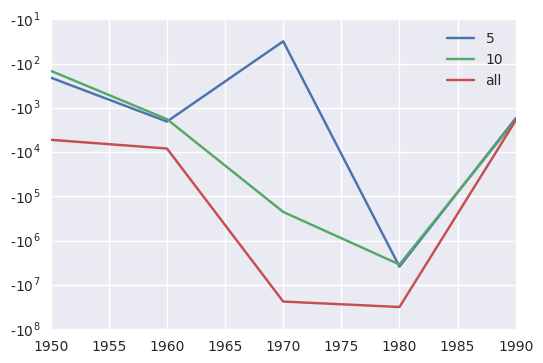

In [18]:
technology_models_prediction['improvement~p(theta)N(mu,sigma)'].mean(axis=0).T.plot()
yscale('symlog')

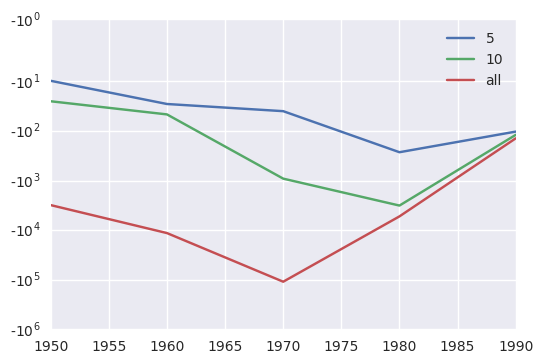

In [19]:
technology_models_prediction['improvement~N(mu,sigma)'].mean(axis=0).T.plot()
yscale('symlog')

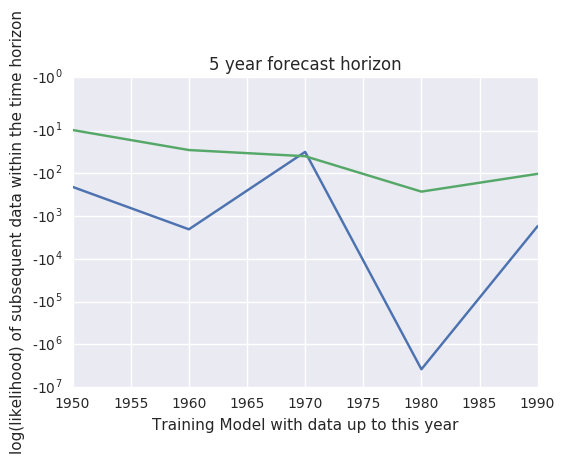

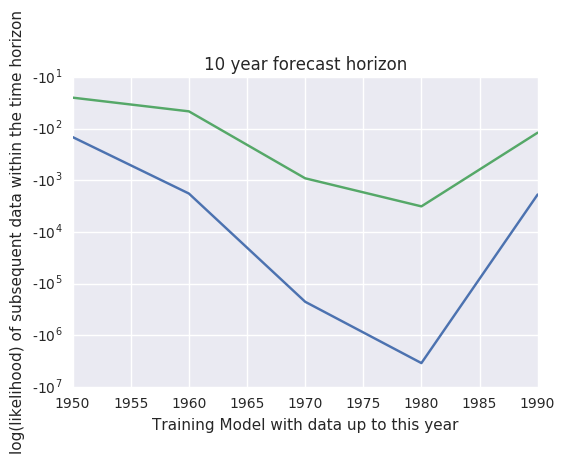

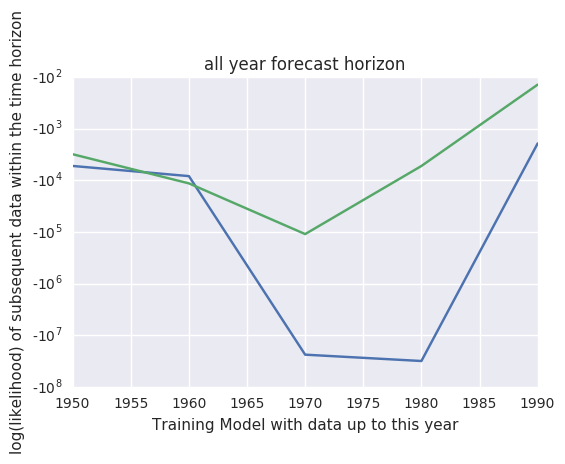

In [20]:
for i in arange(len(horizons)):
    figure()
    technology_models_prediction['improvement~p(theta)N(mu,sigma)'].mean(axis=0).iloc[i].plot(label='p(theta)N(mu,sigma)')
    technology_models_prediction['improvement~N(mu,sigma)'].mean(axis=0).iloc[i].plot(ax=gca(),label='N(mu,sigma)')
    yscale('symlog')
    title(str(horizons[i])+' year forecast horizon')
    xlabel("Training Model with data up to this year")
    ylabel("log(likelihood) of subsequent data within the time horizon")

The model with improvement~N(mu,sigma) (green line) typically predicts the future better than the model with improvement~p(theta)N(mu,sigma) (blue line). The simpler model does better prediction!

Define and test models that evaluate multiple technologies at once
====
Inclues a model that does not pool the technologies at all ('improvement~N(mu,sigma), multiple') and one that uses partial pooling ('improvement~N(mu,sigma), hierarchical')

Note that in the tests both time series are actually independent, and the hierarchical model finds this.

In [21]:
model_code['improvement~N(mu,sigma), multiple'] = """
functions{
    int first_observation_ind(vector my_array){
        int t;
        t = 1;
        while(my_array[t] < -900){
          t = t+1;
        }
        return t;
    }
    
    int last_observation_ind(vector my_array, int length){
        int last_observation;
        last_observation = 0; 
        for(t in 1:length){
          if(my_array[t] > -900){
              last_observation = t;
          }
        }
        return last_observation;
    }
    
    
    int count_n_observations(vector my_array) {
        int count;
        count = 0;
        for (t in 1:num_elements(my_array)) {
            if(my_array[t] > -900){
                count = count + 1;
            }
        }
        return count;
    }
    
    real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
        return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
    }
}

data {
    int N_technologies;
    int N_time_periods; // number of time periods
    vector[N_time_periods] Y[N_technologies]; // value each time period
    
    int N_time_periods_for_inference;
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
 
}

transformed data {
  int first_observation[N_technologies];
  int last_observation[N_technologies];
  int N_observed_time_periods_for_inference[N_technologies];
  int r_observation_offset[N_technologies];
  int n_observations[N_technologies];
  int r_array_offset[N_technologies];

  for (tech in 1:N_technologies){
      first_observation[tech] = first_observation_ind(Y[tech][1:N_time_periods_for_inference]);
      last_observation[tech] = last_observation_ind(Y[tech][1:N_time_periods_for_inference], 
                          N_time_periods_for_inference);

      N_observed_time_periods_for_inference[tech] = last_observation[tech]-first_observation[tech] + 1;
      r_observation_offset[tech] = first_observation[tech]-1;
      n_observations[tech] = count_n_observations(Y[tech]);
  }
  r_array_offset[1] = 0;
  for (tech in 2:N_technologies){
    r_array_offset[tech] = N_observed_time_periods_for_inference[tech-1]+r_array_offset[tech-1]-1;
  }
}
  
parameters {
    real<lower = 0> mu[N_technologies];
    real<lower = 0> sigma[N_technologies];

    vector<lower = 0,upper = 1>[sum(N_observed_time_periods_for_inference)-
                                N_technologies] r_raw; // updates
}

transformed parameters {
  // Identify where the first and last non-missing data points are in Y
  vector<lower = 0>[sum(N_observed_time_periods_for_inference)-
                                N_technologies] r; // updates
  
  {
  // Dictate that the total change between each pair of observations is equal to the observed change between them
  // This is relevant for time periods with missing data
  int most_recent_observation;
  for (tech in 1:N_technologies){
      most_recent_observation = first_observation[tech];
      for(t in first_observation[tech]+1:last_observation[tech]) {
          if(Y[tech][t] > -900) {
            r[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
              (r_array_offset[tech]+(t-1)-r_observation_offset[tech])] = 
            r_raw[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
              (r_array_offset[tech]+(t-1)-r_observation_offset[tech])] /
            sum(r_raw[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
              (r_array_offset[tech]+(t-1)-r_observation_offset[tech])]) * 
            (Y[tech][t]-Y[tech][most_recent_observation]);
            most_recent_observation = t;
            }
        }
      }
  }
}

model {
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

    for (tech in 1:N_technologies){
        for(t in 1:N_observed_time_periods_for_inference[tech]-1){
            target += lower_truncated_normal_lpdf(r[r_array_offset[tech]+t] | mu[tech], sigma[tech], 0);
        }
    }
}

generated quantities {
    vector[N_time_periods] Y_sim[N_technologies];
    vector[N_time_periods] log_likelihood[N_technologies];
    //real mean_change[N_technologies];
    //real variance_change[N_technologies];
    
    //for (tech in 1:N_technologies){
    //    mean_change = mean(r[r_array_offset[tech]:(r_array_offset[tech]+N_observed_time_periods_for_inference[tech])]);
    //    variance_change = variance(r[r_array_offset[tech]:(r_array_offset[tech]+N_observed_time_periods_for_inference[tech])]);
    //}
    
    //Fill out data in the missing periods
    for (tech in 1:N_technologies){
        for(t in first_observation[tech]:last_observation[tech]) {
          if(Y[tech][t] > -900){
              Y_sim[tech][t] = Y[tech][t];
          } else{
              Y_sim[tech][t] = Y_sim[tech][t-1] + r[r_array_offset[tech]+(t-1)-r_observation_offset[tech]];
          } 
        }
    }
    {
    real increase_size;
    //Fill out future data points
    for (tech in 1:N_technologies){
        for(t in last_observation[tech]+1:N_time_periods){
            // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
            // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
            increase_size = -1.0;  
            while (increase_size<0){
                increase_size = normal_rng(mu[tech],sigma[tech]);
            }
            Y_sim[tech][t] = increase_size + Y_sim[tech][t-1];
        }
    }
    }
    
    //Fill out past data points
    {
    int t;
    real increase_size;
    for (tech in 1:N_technologies){
        t = first_observation[tech];
        while(t>1){
            increase_size = -1.0;  
            while (increase_size<0){
                increase_size = normal_rng(mu[tech],sigma[tech]);
            }
            Y_sim[tech][t-1] = Y_sim[tech][t] - increase_size;
            t = t-1;
        }
    }
    }

    for (tech in 1:N_technologies){
        for(t in 2:N_time_periods){
            if(Y[tech][t] > -900){
                    log_likelihood[tech][t] = lower_truncated_normal_lpdf(Y[tech][t]-
                                                                        Y_sim[tech][t-1]| mu[tech], sigma[tech], 0);
            }
        }
    }
}
"""

model_code['improvement~N(mu,sigma), hierarchical'] = """
functions{
    int first_observation_ind(vector my_array){
        int t;
        t = 1;
        while(my_array[t] < -900){
          t = t+1;
        }
        return t;
    }
    
    int last_observation_ind(vector my_array, int length){
        int last_observation;
        last_observation = 0; 
        for(t in 1:length){
          if(my_array[t] > -900){
              last_observation = t;
          }
        }
        return last_observation;
    }
    
    
    int count_n_observations(vector my_array) {
        int count;
        count = 0;
        for (t in 1:num_elements(my_array)) {
            if(my_array[t] > -900){
                count = count + 1;
            }
        }
        return count;
    }
    
    real lower_truncated_normal_lpdf(real x, real mu, real sigma, real A) {
        return(normal_lpdf(x | mu, sigma) - normal_lccdf(A | mu, sigma));
    }
}

data {
    int N_technologies;
    int N_time_periods; // number of time periods
    vector[N_time_periods] Y[N_technologies]; // value each time period
    
    int N_time_periods_for_inference;
    
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
 
}

transformed data {
  int first_observation[N_technologies];
  int last_observation[N_technologies];
  int N_observed_time_periods_for_inference[N_technologies];
  int r_observation_offset[N_technologies];
  int n_observations[N_technologies];
  int r_array_offset[N_technologies];

  for (tech in 1:N_technologies){
      first_observation[tech] = first_observation_ind(Y[tech][1:N_time_periods_for_inference]);
      last_observation[tech] = last_observation_ind(Y[tech][1:N_time_periods_for_inference], 
                          N_time_periods_for_inference);

      N_observed_time_periods_for_inference[tech] = last_observation[tech]-first_observation[tech] + 1;
      r_observation_offset[tech] = first_observation[tech]-1;
      n_observations[tech] = count_n_observations(Y[tech]);
  }
  r_array_offset[1] = 0;
  for (tech in 2:N_technologies){
    r_array_offset[tech] = N_observed_time_periods_for_inference[tech-1]+r_array_offset[tech-1]-1;
  }
}
  
parameters {
    vector<lower = 0>[N_technologies] mu;
    vector<lower = 0>[N_technologies] sigma;

    vector<lower = 0,upper = 1>[sum(N_observed_time_periods_for_inference)-
                                N_technologies] r_raw; // updates
                                
    corr_matrix[2] Omega;
    vector<lower = 0>[2] tau;
    vector<lower=0>[2] mu_parvec;
}

transformed parameters {
  // Identify where the first and last non-missing data points are in Y
  vector<lower = 0>[sum(N_observed_time_periods_for_inference)-
                                N_technologies] r; // updates
  matrix[N_technologies, 2] parvec;
  parvec = append_col(mu, sigma);
  
  {
  // Dictate that the total change between each pair of observations is equal to the observed change between them
  // This is relevant for time periods with missing data
  int most_recent_observation;
  for (tech in 1:N_technologies){
      most_recent_observation = first_observation[tech];
      for(t in first_observation[tech]+1:last_observation[tech]) {
          if(Y[tech][t] > -900) {
            r[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
              (r_array_offset[tech]+(t-1)-r_observation_offset[tech])] = 
            r_raw[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
              (r_array_offset[tech]+(t-1)-r_observation_offset[tech])] /
            sum(r_raw[(r_array_offset[tech]+most_recent_observation-r_observation_offset[tech]):
              (r_array_offset[tech]+(t-1)-r_observation_offset[tech])]) * 
            (Y[tech][t]-Y[tech][most_recent_observation]);
            most_recent_observation = t;
            }
        }
      }
  }  
}

model {
    tau ~ cauchy(0, 1);
    Omega ~ lkj_corr(4);
    mu_parvec[1] ~ student_t(3, 1, 1);
    mu_parvec[2] ~ student_t(3, 0.5, 0.5);
    
    for (tech in 1:N_technologies){
        parvec[tech] ~ multi_normal(mu_parvec, quad_form_diag(Omega, tau));
        for(t in 1:N_observed_time_periods_for_inference[tech]-1){
            target += lower_truncated_normal_lpdf(r[r_array_offset[tech]+t] | mu[tech], sigma[tech], 0);
        }
    }
}

generated quantities {
    vector[N_time_periods] Y_sim[N_technologies];
    vector[N_time_periods] log_likelihood[N_technologies];
    //real mean_change[N_technologies];
    //real variance_change[N_technologies];
    
    //for (tech in 1:N_technologies){
    //    mean_change = mean(r[r_array_offset[tech]:(r_array_offset[tech]+N_observed_time_periods_for_inference[tech])]);
    //    variance_change = variance(r[r_array_offset[tech]:(r_array_offset[tech]+N_observed_time_periods_for_inference[tech])]);
    //}
    
    //Fill out data in the missing periods
    for (tech in 1:N_technologies){
        for(t in first_observation[tech]:last_observation[tech]) {
          if(Y[tech][t] > -900){
              Y_sim[tech][t] = Y[tech][t];
          } else{
              Y_sim[tech][t] = Y_sim[tech][t-1] + r[r_array_offset[tech]+(t-1)-r_observation_offset[tech]];
          } 
        }
    }
    {
    real increase_size;
    //Fill out future data points
    for (tech in 1:N_technologies){
        for(t in last_observation[tech]+1:N_time_periods){
            // Stan cannot yet generate numbers from a truncated distribution directly, so we have to do this silly thing. 
            // As of version 2.12.0, the devs are still talking about it: https://github.com/stan-dev/math/issues/214
            increase_size = -1.0;  
            while (increase_size<0){
                increase_size = normal_rng(mu[tech],sigma[tech]);
            }
            Y_sim[tech][t] = increase_size + Y_sim[tech][t-1];
        }
    }
    }
    
    //Fill out past data points
    {
    int t;
    real increase_size;
    for (tech in 1:N_technologies){
        t = first_observation[tech];
        while(t>1){
            increase_size = -1.0;  
            while (increase_size<0){
                increase_size = normal_rng(mu[tech],sigma[tech]);
            }
            Y_sim[tech][t-1] = Y_sim[tech][t] - increase_size;
            t = t-1;
        }
    }
    }

    for (tech in 1:N_technologies){
        for(t in 2:N_time_periods){
            if(Y[tech][t] > -900){
                    log_likelihood[tech][t] = lower_truncated_normal_lpdf(Y[tech][t]-
                                                                        Y_sim[tech][t-1]| mu[tech], sigma[tech], 0);
            }
        }
    }
}
"""

In [22]:
### Random walk, missing data, positive steps, multiple technologies
p_missing = 0.3
mu = 5
sigma = 1
n = 100


a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
missing[-1] = False
time_series[missing]=nan

time_series0 = time_series


p_missing = 0.2
mu = 3
sigma = 2
n = 100


a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
missing[-1] = False
time_series[missing]=nan

time_series1 = time_series


stan_data = {'N_technologies': 2,
            'N_time_periods': n,
            'N_time_periods_for_inference': n,
             'Y': pd.DataFrame([time_series0, time_series1]).fillna(-999).values,
            'mu_prior_location': 3,
            'mu_prior_scale': 1,
            'sigma_prior_location': 1,
            'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code['improvement~N(mu,sigma), multiple'], data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma']))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5902ce09c1e2e610d53226b05e0f4480 NOW.


NOT reusing model.
Ran in 75.286 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      5.01  2.1e-3   0.13   4.75   4.92   5.01    5.1   5.27   4000    1.0
mu[1]      2.54  4.3e-3   0.23   2.01    2.4   2.56   2.71   2.95   2985    1.0
sigma[0]   1.29  1.6e-3    0.1   1.11   1.22   1.29   1.36   1.52   4000    1.0
sigma[1]   1.74  3.8e-3    0.2   1.41    1.6   1.72   1.86    2.2   2721    1.0

Samples were drawn using NUTS at Sat Nov 12 06:46:28 2016.



In [23]:
### Random walk, missing data, positive steps, multiple technologies, hierarchical
p_missing = 0.3
mu = 5
sigma = 1
n = 100


a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
missing[-1] = False
time_series[missing]=nan

time_series0 = time_series


p_missing = 0.2
mu = 3
sigma = 2
n = 100


a = -mu / sigma
data = truncnorm(a, inf, loc=mu,scale=sigma).rvs(n)

time_series = cumsum(data)
missing = rand(n)<p_missing
missing[0] = False
missing[-1] = False
time_series[missing]=nan

time_series1 = time_series


stan_data = {'N_technologies': 2,
            'N_time_periods': n,
            'N_time_periods_for_inference': n,
             'Y': pd.DataFrame([time_series0, time_series1]).fillna(-999).values,
            'mu_prior_location': 3,
            'mu_prior_scale': 1,
            'sigma_prior_location': 1,
            'sigma_prior_scale': 2}

model_fit = stanity.fit(model_code['improvement~N(mu,sigma), hierarchical'], data=stan_data, n_jobs=n_jobs)

print(_print_stanfit(model_fit, ['mu', 'sigma', 'Omega']))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_99df85efa35d6e96559705657489cfd3 NOW.


NOT reusing model.
Ran in 94.623 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]        4.87  1.5e-3   0.09   4.69   4.81   4.87   4.94   5.06   4000    1.0
mu[1]        3.33  5.1e-3   0.32   2.61   3.14   3.36   3.55    3.9   4000    1.0
sigma[0]     0.92  1.3e-3   0.08   0.78   0.86   0.92   0.97   1.09   4000    1.0
sigma[1]     2.28  4.0e-3   0.25   1.87    2.1   2.25   2.42   2.86   4000    1.0
Omega[0,0]    1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   4000    nan
Omega[1,0]  -0.02  5.2e-3   0.33  -0.65  -0.25  -0.02   0.21   0.59   4000    1.0
Omega[0,1]  -0.02  5.2e-3   0.33  -0.65  -0.25  -0.02   0.21   0.59   4000    1.0
Omega[1,1]    1.0 1.4e-188.8e-17    1.0    1.0    1.0    1.0    1.0   4000    nan

Samples were drawn using NUTS at Sat Nov 12 06:48:03 2016.



Fit models to empirical data and forecast the future
====

In [24]:
data = pd.read_csv(data_directory+'time_series.csv',index_col=0)
data = data.reindex(arange(data.index[0],data.index[-1]+1))
metadata = pd.read_csv(data_directory+'time_series_metadata.csv')
technology_models_prediction = {}

In [28]:
target_tech_names = metadata.ix[metadata['Type']=='Performance', 'Name']
print("%i technologies"%target_tech_names.shape[0])

training_years = arange(1950,2000,10)
horizons = [5,10,'all']

technology_models_prediction['improvement~N(mu,sigma), multiple'] = pd.Panel(items=target_tech_names,
         major_axis=horizons+['mu', 'sigma'], 
         minor_axis=training_years)

first_year = data.index[0]

time_series = data[target_tech_names]
time_series = log10(time_series**-1)

for training_year in training_years:
    print(training_year)

    start_ind = int(training_year-first_year)
    time_series_from_time_period = time_series.columns[time_series.iloc[:start_ind].notnull().sum(axis=0)>2]
    n_time_series_from_time_period = len(time_series_from_time_period)
    stan_data = {'N_technologies': n_time_series_from_time_period,
                 'N_time_periods': time_series.shape[0],
            'N_time_periods_for_inference': start_ind,
             'Y': time_series[time_series_from_time_period].fillna(-999).T,
                 'mu_prior_location': .1,
                'mu_prior_scale': 2,
                'sigma_prior_location': 1,
                'sigma_prior_scale': 2}

    ###
    model_fit = stanity.fit(model_code['improvement~N(mu,sigma), multiple'], data=stan_data, n_jobs=n_jobs)
    print(_print_stanfit(model_fit, ['mu', 'sigma']))
    technology_models_prediction['improvement~N(mu,sigma), multiple'].ix[time_series_from_time_period,
                                                                             'mu',training_year] = model_fit['mu'].mean(axis=0)
    technology_models_prediction['improvement~N(mu,sigma), multiple'].ix[time_series_from_time_period,
                                                                             'mu',training_year] = model_fit['sigma'].mean(axis=0)
    
    for horizon in horizons:
        if horizon=='all':
            ll = nanmean(nanmean(model_fit['log_likelihood'][:,:,start_ind:],axis=0),axis=1)
        else:
            ll = nanmean(nanmean(model_fit['log_likelihood'][:,:,start_ind:start_ind+horizon],axis=0),axis=1)
        technology_models_prediction['improvement~N(mu,sigma), multiple'].ix[time_series_from_time_period,
                                                                             horizon,training_year] = ll

38 technologies
1950
Reusing model.
Ran in 79.026 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]     4.8e-3  7.0e-5 4.4e-3 1.6e-4 1.6e-3 3.5e-3 6.6e-3   0.02   4000    1.0
mu[1]       0.26  3.6e-3   0.15   0.02   0.14   0.25   0.35   0.57   1829    1.0
mu[2]       0.15  5.0e-3   0.09 7.3e-3   0.08   0.15   0.21   0.35    322   1.01
mu[3]     1.7e-3  3.8e-5 1.5e-3 7.2e-5 5.7e-4 1.4e-3 2.4e-3 5.7e-3   1520    1.0
mu[4]     1.8e-3  1.1e-4 1.6e-3 5.8e-5 5.7e-4 1.4e-3 2.7e-3 5.4e-3    220   1.01
mu[5]       0.83  7.6e-3   0.23   0.16   0.81   0.88   0.92   1.21    946    1.0
mu[6]       0.02  6.9e-4   0.01 4.2e-4 4.6e-3   0.01   0.02   0.05    392   1.01
mu[7]     7.7e-3  6.2e-4 6.6e-3 1.8e-4 2.4e-3 6.0e-3   0.01   0.02    114   1.04
mu[8]     3.9e-3  5.5e-5 3.5e-3 1.3e-4 1.3e-3 3.0e-3 5.4e-3   0.01   4000    1.0
mu[9]     8.0e-3 

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


1960
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 97.943 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]        0.1  1.2e-3   0.05 8.0e-3   0.07   0.11   0.13   0.18   1569    1.0
mu[1]        0.1  1.3e-3   0.05 6.4e-3   0.07   0.11   0.13   0.18   1567    1.0
mu[2]     5.6e-3  8.3e-5 5.2e-3 1.3e-4 1.6e-3 4.1e-3 8.0e-3   0.02   4000    1.0
mu[3]       0.11  1.7e-3   0.07 5.6e-3   0.05    0.1   0.16   0.27   1899    1.0
mu[4]       0.17  2.1e-3   0.06   0.02   0.14   0.18   0.21   0.25    748   1.01
mu[5]       0.09  1.9e-3   0.06 4.4e-3   0.04   0.09   0.14   0.22   1027    1.0
mu[6]       0.08  1.3e-3   0.05 5.7e-3   0.04   0.08   0.12   0.19   1530    1.0
mu[7]     1.6e-3  2.2e-5 1.4e-3 3.2e-5 4.8e-4 1.2e-3 2.2e-3 5.3e-3   4000    1.0
mu[8]     1.6e-3  2.3e-5 1.5e-3 3.6e-5 4.9e-4 1.2e-3 2.3e-3 5.4e-3   4000    1.0
mu[9]       0.81    0.02   0.24   0.11   0.81   0.88 

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 174.839 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.25  2.4e-3   0.09   0.03   0.21   0.27    0.3    0.4   1444    1.0
mu[1]       0.05  7.0e-4   0.03 1.8e-3   0.02   0.05   0.07    0.1   1768    1.0
mu[2]       0.24  6.2e-4   0.02    0.2   0.23   0.24   0.24   0.27    802    1.0
mu[3]       0.05  6.2e-4   0.03 3.1e-3   0.03   0.05   0.07    0.1   2199    1.0
mu[4]     4.9e-3  7.5e-5 4.7e-3 1.1e-4 1.4e-3 3.5e-3 6.9e-3   0.02   4000    1.0
mu[5]       0.06  8.1e-4   0.03 4.3e-3   0.03   0.06   0.08   0.12   1520    1.0
mu[6]       0.05  8.6e-5 3.5e-3   0.05   0.05   0.05   0.06   0.06   1656    1.0
mu[7]       0.02  3.6e-6 2.3e-4   0.02   0.02   0.02   0.02   0.02   4000    nan
mu[8]        0.1  1.3e-3   0.07 4.4e-3   0.05    0.1   0.15   0.24   2450    1.0
mu[9]       0.11  1.7e-3   0.05 8.4e-3   0.08   0.12

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 254.484 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]        0.2  2.2e-3   0.07   0.02   0.17   0.22   0.25    0.3   1012    1.0
mu[1]       0.17  2.1e-3   0.06   0.03   0.15   0.18    0.2   0.28    744    1.0
mu[2]       0.05  8.4e-4   0.02 2.9e-3   0.03   0.05   0.07   0.09    881    1.0
mu[3]       0.11  1.5e-3   0.06 7.7e-3   0.06   0.11   0.15   0.21   1425    1.0
mu[4]       0.05  9.7e-4   0.03 3.4e-3   0.03   0.05   0.07   0.09    704   1.01
mu[5]     5.4e-3  8.0e-5 5.1e-3 1.5e-4 1.7e-3 4.0e-3 7.5e-3   0.02   4000    1.0
mu[6]       0.06  9.2e-4   0.03 3.3e-3   0.03   0.05   0.08   0.12   1186    1.0
mu[7]       0.05  6.4e-5 2.9e-3   0.04   0.05   0.05   0.05   0.06   1972    1.0
mu[8]       0.02  3.8e-5 1.8e-3   0.02   0.02   0.02   0.02   0.03   2271    1.0
mu[9]       0.05  6.3e-4   0.04 1.6e-3   0.02   0.04

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 119.898 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.19  1.5e-3   0.05   0.05   0.17   0.21   0.23   0.26   1204    1.0
mu[1]       0.16  1.4e-3   0.04   0.05   0.15   0.17   0.18   0.21    659    1.0
mu[2]       0.04  5.5e-4   0.02 1.7e-3   0.02   0.04   0.05   0.07   1321    1.0
mu[3]       0.06  7.3e-4   0.04 3.2e-3   0.03   0.06   0.09   0.14   2823    1.0
mu[4]       0.02  3.1e-4   0.02 8.2e-4 9.8e-3   0.02   0.04   0.06   2873    1.0
mu[5]     5.9e-3  8.6e-5 5.4e-3 2.0e-4 1.7e-3 4.3e-3 8.4e-3   0.02   4000    1.0
mu[6]       0.01  1.9e-4   0.01 2.8e-4 3.4e-3 8.8e-3   0.02   0.04   4000    1.0
mu[7]     7.3e-3  1.0e-4 6.6e-3 1.9e-4 2.2e-3 5.6e-3   0.01   0.02   4000    1.0
mu[8]     2.6e-3  4.0e-5 2.5e-3 8.5e-5 8.4e-4 1.9e-3 3.7e-3 9.4e-3   4000    1.0
mu[9]       0.05  6.2e-4   0.04 1.8e-3   0.02   0.04

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675:

In [29]:
target_tech_names = metadata.ix[metadata['Type']=='Performance', 'Name']
print("%i technologies"%target_tech_names.shape[0])

training_years = arange(1950,2000,10)
horizons = [5,10,'all']

technology_models_prediction['improvement~N(mu,sigma), hierarchical'] = pd.Panel(items=target_tech_names,
         major_axis=horizons, 
         minor_axis=training_years)

first_year = data.index[0]

time_series = data[target_tech_names]
time_series = log10(time_series**-1)

for training_year in training_years:
    print(training_year)

    start_ind = int(training_year-first_year)
    time_series_from_time_period = time_series.columns[time_series.iloc[:start_ind].notnull().sum(axis=0)>2]
    n_time_series_from_time_period = len(time_series_from_time_period)
    stan_data = {'N_technologies': n_time_series_from_time_period,
                 'N_time_periods': time_series.shape[0],
            'N_time_periods_for_inference': start_ind,
             'Y': time_series[time_series_from_time_period].fillna(-999).T,
                     'mu_prior_location': .1,
                    'mu_prior_scale': 2,
                    'sigma_prior_location': 1,
                    'sigma_prior_scale': 2}

    ###
    model_fit = stanity.fit(model_code['improvement~N(mu,sigma), hierarchical'], data=stan_data, n_jobs=n_jobs)
    print(_print_stanfit(model_fit, ['mu', 'sigma']))

    for horizon in horizons:
        if horizon=='all':
            ll = nanmean(nanmean(model_fit['log_likelihood'][:,:,start_ind:],axis=0),axis=1)
        else:
            ll = nanmean(nanmean(model_fit['log_likelihood'][:,:,start_ind:start_ind+horizon],axis=0),axis=1)
        technology_models_prediction['improvement~N(mu,sigma), hierarchical'].ix[time_series_from_time_period,
                                                                             horizon,training_year] = ll

38 technologies
1950
Reusing model.
Ran in 83.200 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]     7.4e-4  2.5e-5 6.0e-4 6.4e-5 3.1e-4 6.0e-4 9.6e-4 2.3e-3    580    nan
mu[1]     8.0e-4  2.8e-5 7.1e-4 5.1e-5 3.1e-4 6.5e-4 1.0e-3 2.7e-3    643    nan
mu[2]     7.9e-4  2.6e-5 6.7e-4 5.4e-5 3.2e-4 6.4e-4 1.0e-3 2.7e-3    661    nan
mu[3]     6.9e-4  2.2e-5 5.6e-4 4.7e-5 2.8e-4 5.7e-4 9.3e-4 2.1e-3    625    nan
mu[4]     6.9e-4  2.2e-5 5.5e-4 4.6e-5 2.9e-4 5.8e-4 9.1e-4 2.1e-3    634    nan
mu[5]     8.5e-4  3.0e-5 8.1e-4 4.4e-5 3.2e-4 6.7e-4 1.1e-3 3.0e-3    726    nan
mu[6]     7.6e-4  2.5e-5 6.4e-4 5.5e-5 3.1e-4 6.1e-4 9.9e-4 2.4e-3    649    nan
mu[7]     7.4e-4  2.4e-5 6.1e-4 5.7e-5 3.1e-4 6.0e-4 9.6e-4 2.4e-3    624    nan
mu[8]     7.3e-4  2.3e-5 5.8e-4 5.8e-5 3.1e-4 6.1e-4 9.6e-4 2.3e-3    613    nan
mu[9]     7.4e-4 

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


1960
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 209.910 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]     6.9e-4  5.5e-5 6.0e-4 7.0e-5 2.9e-4 5.2e-4 9.2e-4 2.2e-3    119    nan
mu[1]     6.8e-4  5.6e-5 5.9e-4 7.8e-5 2.8e-4 5.1e-4 9.1e-4 2.1e-3    112    nan
mu[2]     6.6e-4  5.4e-5 5.5e-4 7.3e-5 2.8e-4 5.0e-4 8.9e-4 2.1e-3    103    nan
mu[3]     7.1e-4  6.1e-5 6.7e-4 6.9e-5 2.8e-4 5.2e-4 9.5e-4 2.4e-3    121    nan
mu[4]     6.9e-4  5.4e-5 6.1e-4 8.1e-5 2.7e-4 5.2e-4 9.3e-4 2.3e-3    127    nan
mu[5]     7.0e-4  5.6e-5 5.9e-4 7.4e-5 3.0e-4 5.3e-4 9.4e-4 2.3e-3    110    nan
mu[6]     6.9e-4  5.6e-5 5.8e-4 7.3e-5 3.0e-4 5.2e-4 9.3e-4 2.2e-3    109    nan
mu[7]     6.2e-4  4.7e-5 4.8e-4 6.5e-5 2.8e-4 4.7e-4 8.3e-4 1.8e-3    105    nan
mu[8]     6.1e-4  4.3e-5 4.9e-4 6.9e-5 2.8e-4 4.8e-4 8.2e-4 1.8e-3    131    nan
mu[9]     7.7e-4  5.0e-5 8.0e-4 5.3e-5 2.7e-4 5.2e-4

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


1970
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 339.078 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]     9.4e-3  4.1e-3 9.2e-3 1.3e-4 1.1e-3 7.7e-3   0.01   0.03      5   1.25
mu[1]     7.1e-3  2.9e-3 6.6e-3 1.2e-4 1.0e-3 5.9e-3   0.01   0.02      5   1.26
mu[2]     8.7e-3  3.8e-3 8.4e-3 1.3e-4 1.1e-3 7.3e-3   0.01   0.03      5   1.25
mu[3]     7.2e-3  3.1e-3 6.9e-3 1.4e-4 9.7e-4 6.0e-3   0.01   0.02      5   1.25
mu[4]     3.8e-3  1.5e-3 3.7e-3 1.0e-4 7.0e-4 2.8e-3 5.9e-3   0.01      6   1.19
mu[5]     7.3e-3  3.0e-3 6.8e-3 1.2e-4 1.1e-3 6.2e-3   0.01   0.02      5   1.25
mu[6]     9.4e-3  4.1e-3   0.01 1.4e-4 1.1e-3 7.2e-3   0.01   0.04      6   1.22
mu[7]       0.02  5.9e-3 8.4e-3 1.5e-4 9.5e-3   0.02   0.02   0.02      2    nan
mu[8]     9.2e-3  3.8e-3 8.5e-3 1.3e-4 1.2e-3 7.8e-3   0.01   0.03      5   1.28
mu[9]     8.1e-3  3.4e-3 7.6e-3 1.3e-4 1.0e-3 6.6e-3

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


1980
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 467.753 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]     4.3e-4  4.5e-5 3.5e-4 4.5e-5 1.6e-4 3.3e-4 5.9e-4 1.3e-3     59    nan
mu[1]     4.2e-4  4.4e-5 3.5e-4 4.3e-5 1.6e-4 3.3e-4 5.7e-4 1.3e-3     61    nan
mu[2]     4.1e-4  4.6e-5 3.3e-4 4.5e-5 1.6e-4 3.3e-4 5.5e-4 1.3e-3     51    nan
mu[3]     4.1e-4  4.3e-5 3.4e-4 4.1e-5 1.5e-4 3.3e-4 5.8e-4 1.2e-3     62    nan
mu[4]     4.1e-4  4.2e-5 3.2e-4 4.3e-5 1.5e-4 3.3e-4 5.5e-4 1.2e-3     58    nan
mu[5]     4.0e-4  4.2e-5 3.2e-4 4.5e-5 1.5e-4 3.2e-4 5.4e-4 1.1e-3     58    nan
mu[6]     4.1e-4  4.5e-5 3.3e-4 4.5e-5 1.5e-4 3.3e-4 5.7e-4 1.2e-3     55    nan
mu[7]     4.0e-4  4.7e-5 3.1e-4 4.2e-5 1.6e-4 3.3e-4 5.5e-4 1.2e-3     45    nan
mu[8]     4.1e-4  4.1e-5 3.2e-4 4.7e-5 1.6e-4 3.3e-4 5.6e-4 1.2e-3     64    nan
mu[9]     4.2e-4  4.3e-5 3.4e-4 4.9e-5 1.6e-4 3.3e-4

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


1990
Reusing model.


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Ran in 423.909 sec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]     3.5e-4  2.4e-5 3.0e-4 3.9e-5 1.4e-4 2.7e-4 4.9e-4 1.1e-3    159    nan
mu[1]     3.5e-4  2.4e-5 2.8e-4 3.7e-5 1.4e-4 2.7e-4 4.8e-4 1.1e-3    145    nan
mu[2]     3.3e-4  2.2e-5 2.7e-4 3.8e-5 1.4e-4 2.6e-4 4.6e-4 9.7e-4    149    nan
mu[3]     3.5e-4  2.3e-5 2.8e-4 3.8e-5 1.4e-4 2.7e-4 4.8e-4 1.1e-3    149    nan
mu[4]     3.3e-4  2.2e-5 2.7e-4 3.7e-5 1.4e-4 2.6e-4 4.6e-4 1.0e-3    157    nan
mu[5]     3.4e-4  2.2e-5 2.6e-4 4.4e-5 1.4e-4 2.7e-4 4.8e-4 1.0e-3    146    nan
mu[6]     3.6e-4  2.4e-5 2.9e-4 3.4e-5 1.4e-4 2.8e-4 5.0e-4 1.1e-3    153    nan
mu[7]     3.4e-4  2.2e-5 2.7e-4 3.9e-5 1.4e-4 2.6e-4 4.7e-4 1.1e-3    153    nan
mu[8]     3.3e-4  2.2e-5 2.7e-4 3.6e-5 1.3e-4 2.6e-4 4.6e-4 1.0e-3    153    nan
mu[9]     3.5e-4  2.3e-5 2.8e-4 3.9e-5 1.4e-4 2.7e-4

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675:

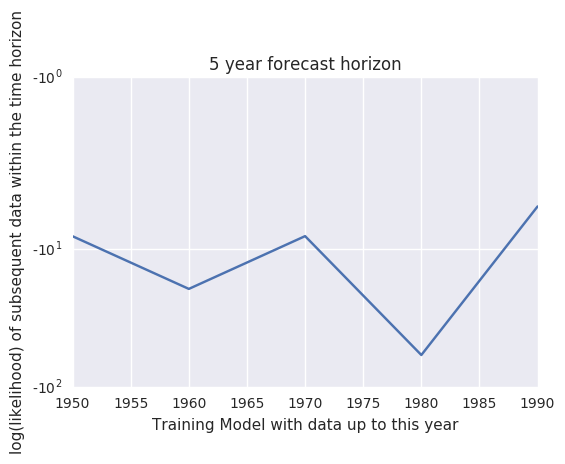

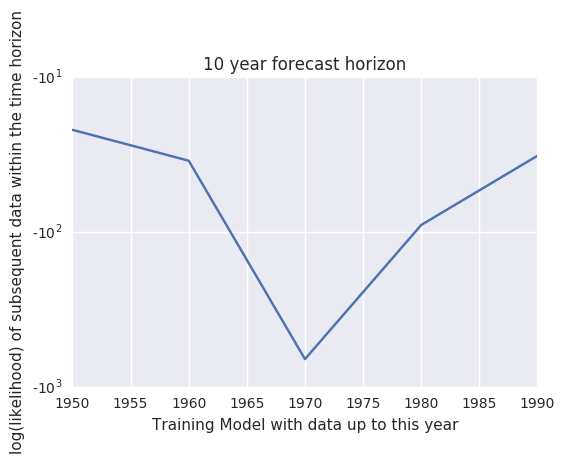

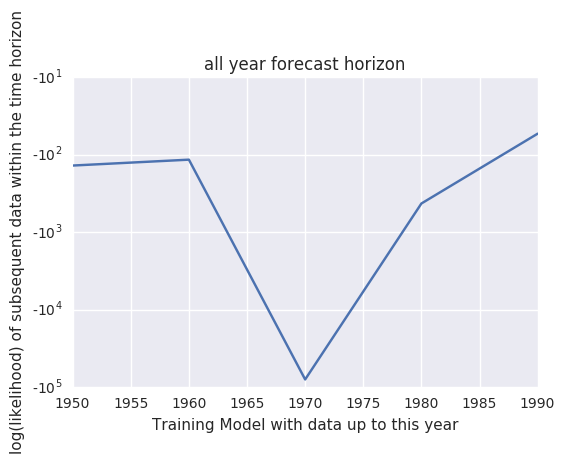

In [32]:
for i in arange(len(horizons)):
    figure()
#     technology_models_prediction['improvement~N(mu,sigma), multiple'].mean(axis=0).iloc[i].plot(ax=gca(),label='N(mu,sigma)')
    technology_models_prediction['improvement~N(mu,sigma), hierarchical'].mean(axis=0).iloc[i].plot(ax=gca(),label='N(mu,sigma), hierarchical')

    yscale('symlog')
    title(str(horizons[i])+' year forecast horizon')
    xlabel("Training Model with data up to this year")
    ylabel("log(likelihood) of subsequent data within the time horizon")

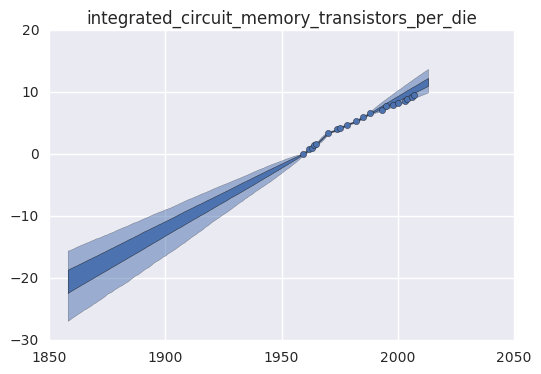

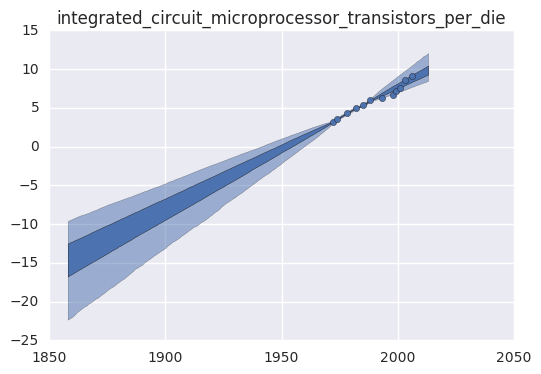

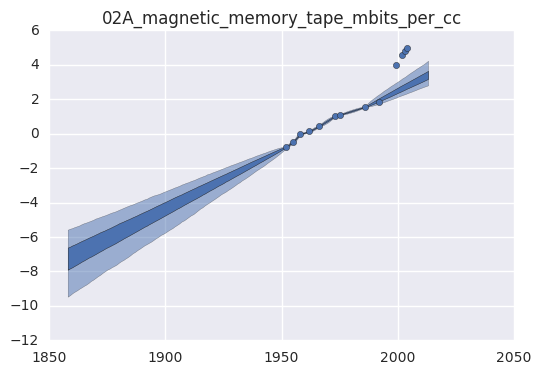

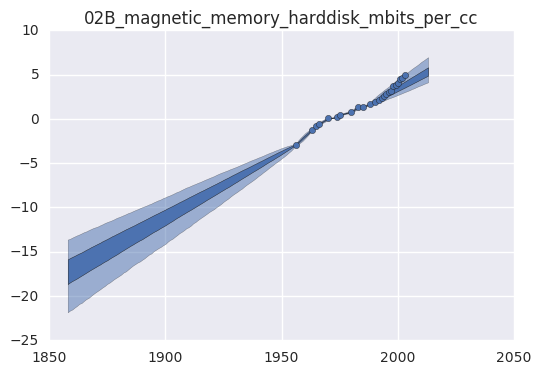

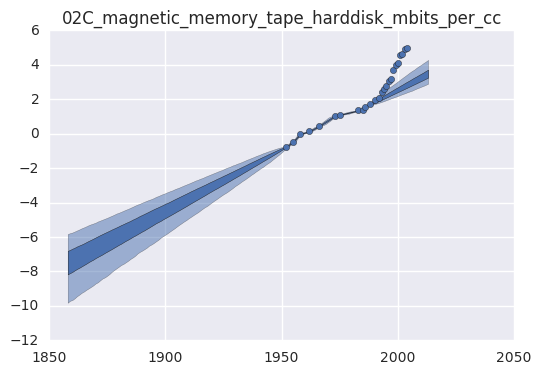

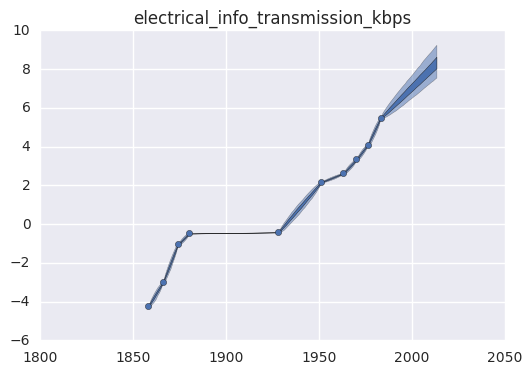

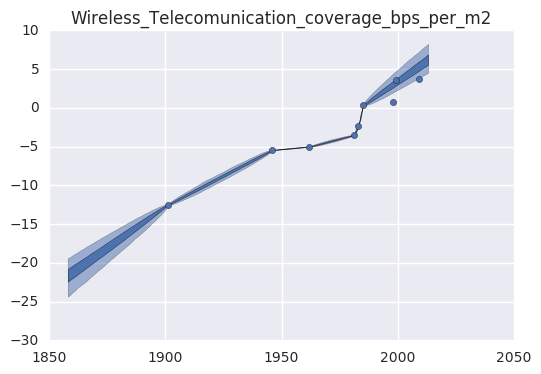

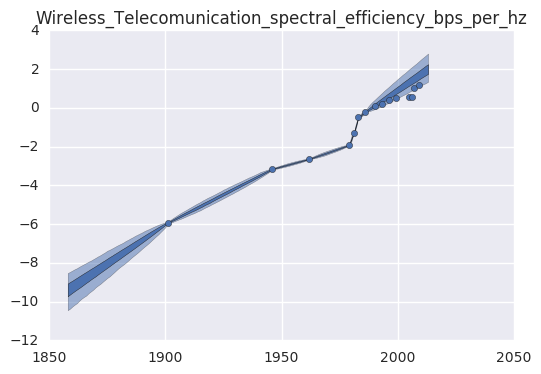

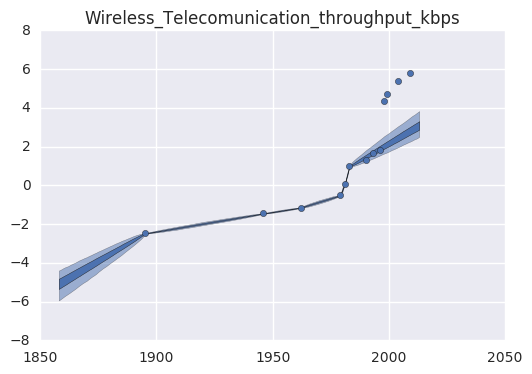

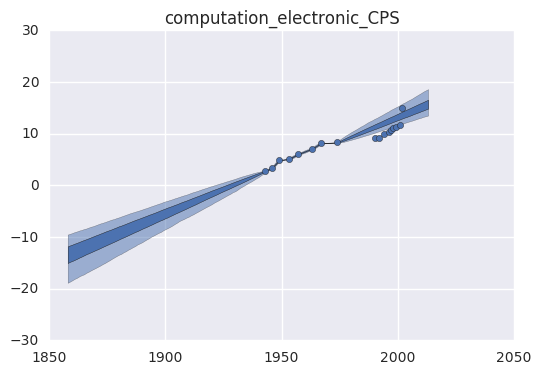

In [33]:
for i in arange(len(time_series_from_time_period))[:10]:
    figure()
    title(time_series_from_time_period[i])
    plot_time_series_inference(model_fit,ind=i, x=data.index.values)
    scatter(time_series.index, time_series[time_series_from_time_period[i]])